<a href="https://colab.research.google.com/github/JMauroSH/Prediccion_Ventas/blob/main/Predicciones_con_3_modelos_con_todos_los_datos_y_desde_2021_productoTOP_1_SegundaSucursal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
from pandas import set_option, read_csv, to_datetime, merge, date_range, Series, Timedelta, DataFrame
from numpy import abs, array, mean, sqrt, where, nan, sum
from matplotlib.pyplot import plot, xlim, ylim, title, show, xlabel, ylabel, legend, figure, style, rcParams, subplots, tight_layout, xticks
from seaborn import set_palette

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
set_option('display.float_format', '{:.4f}'.format)


In [ ]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = read_csv(file_path)
df.head()

,CodigoSucursal,CodigoDepartamento,CodigoEstado,TipoMovimiento,DescripcionMovimiento,NumeroMovimiento,NumeroCorrelativo,FechaMovimiento,NombreProducto,UnidadMedida,CantidadSalida,PesoSalida,MontoBase,PrecioUnitario,CostoUnitario,MontoReferencia,NombreGrupo
0,13,1,AC,SVE,VENTA COMPUTARIZADA,18112056,0,2018-11-15,CUELLO,KG,0.0000,0.6532,2.5760,3.5880,3.5880,0.3698,TROZADO
1,13,1,AC,SVE,VENTA COMPUTARIZADA,18112055,0,2018-11-15,FILETE A GRANEL,KG,0.0000,1.9826,47.0120,21.8040,21.8040,6.7546,TROZADO
2,13,1,AC,SVE,VENTA COMPUTARIZADA,18112052,0,2018-11-15,FILETE A GRANEL,KG,0.0000,1.9246,45.6320,21.8040,21.8040,6.5559,TROZADO
3,13,1,AC,SVE,VENTA COMPUTARIZADA,18112050,0,2018-11-15,FILETE A GRANEL,KG,0.0000,0.8418,19.9640,21.8040,21.8040,2.8686,TROZADO
4,13,1,AC,SVE,VENTA COMPUTARIZADA,18112049,0,2018-11-15,PIERNA,KG,0.0000,0.1334,2.1160,14.7200,14.7200,0.3036,TROZADO


In [ ]:
df['FechaMovimiento'] = to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [ ]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase'
              ]]

In [ ]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


### seleccion del top 1

In [ ]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Seleccionar el nombre del primer producto
nombre_primer_producto = top_10_productos.index[0]

# Crear un DataFrame solo con las ventas del primer producto y un registro por día
df_top_1 = df_todo[df_todo['NombreProducto'] == nombre_primer_producto].groupby(['FechaMovimiento', 'NombreProducto']).sum().reset_index()

# Imprimir el DataFrame df_top_1
print("\nDataFrame df_top_1:")
print(df_top_1)

Nombres de los 10 productos más vendidos:
Index(['POLLO ESPECIAL', 'POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA',
       'FILETE A GRANEL', 'ALA PRIMERA', 'PIERNA', 'MUSLO', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0            POLLO ESPECIAL         1731
1                    PIERNA         1671
2  POLLO SIN MENUDENCIA H-C         1650
3           FILETE A GRANEL         1603
4                     MUSLO         1588
5                    CUELLO         1456
6              PIERNA MUSLO         1408
7                   PECHUGA         1399
8                    HIGADO         1364
9               ALA PRIMERA         1321

DataFrame df_top_1:
     FechaMovimiento  NombreProducto  MontoBase
0         2018-11-01  POLLO ESPECIAL  1140.6240
1         2018-11-02  POLLO ESPECIAL  1645.2540
2         2018-11-03  POLLO ESPECIAL   712.9790
3         2018-11-04  POLLO ESPECIAL  1343.633

In [ ]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_top_1[(df_top_1['FechaMovimiento'] >= '2023-11-01') & (df_top_1['FechaMovimiento'] <= '2023-11-30')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_top_1[df_top_1['FechaMovimiento'] < '2023-11-01']

df_top_1 = df_top_1[df_top_1['FechaMovimiento'] < '2023-12-01']

In [ ]:
print("todo ", df_todo.shape)
print("sin noviembre ", df_todo_hasta_nov.shape)
print("noviembre 2023 ", df_noviembre.shape)

todo  (196059, 3)
sin noviembre  (1698, 3)
noviembre 2023  (29, 3)


### verificar las fechas faltantes y rellenarlas

In [ ]:
from sklearn.impute import KNNImputer
from copy import deepcopy

In [ ]:
#df_noviembre.head()
print(df_todo_hasta_nov)
print(df_todo_hasta_nov.dtypes)

     FechaMovimiento  NombreProducto  MontoBase
0         2018-11-01  POLLO ESPECIAL  1140.6240
1         2018-11-02  POLLO ESPECIAL  1645.2540
2         2018-11-03  POLLO ESPECIAL   712.9790
3         2018-11-04  POLLO ESPECIAL  1343.6330
4         2018-11-05  POLLO ESPECIAL  1755.2580
...              ...             ...        ...
1693      2023-10-27  POLLO ESPECIAL  2152.1624
1694      2023-10-28  POLLO ESPECIAL  2499.2891
1695      2023-10-29  POLLO ESPECIAL  1611.2471
1696      2023-10-30  POLLO ESPECIAL  3372.2990
1697      2023-10-31  POLLO ESPECIAL  2112.0323

[1698 rows x 3 columns]
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object


In [ ]:
df_todas_fechas_hasta_nov = deepcopy(df_todo_hasta_nov)

# Convertir la columna 'FechaMovimiento' a tipo datetime si aún no lo está
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# Establecer 'FechaMovimiento' como el índice
df_todas_fechas_hasta_nov.set_index('FechaMovimiento', inplace=True)

# Reindexar para incluir todas las fechas desde el inicio hasta el final del rango deseado
inicio = df_todas_fechas_hasta_nov.index.min()
fin = df_todas_fechas_hasta_nov.index.max()
fechas_completas = date_range(start=inicio, end=fin)

# Contar cuántas fechas faltantes se agregaron
fechas_faltantes = fechas_completas.difference(df_todas_fechas_hasta_nov.index)
contador_fechas_faltantes = len(fechas_faltantes)

# Reindexar el DataFrame para incluir todas las fechas
df_todas_fechas_hasta_nov = df_todas_fechas_hasta_nov.reindex(fechas_completas)

# # Rellenar los valores faltantes utilizando KNNImputer
# imputer = KNNImputer(n_neighbors=5)  # Puedes ajustar el número de vecinos según tu preferencia
# df_todas_fechas_hasta_nov['MontoBase'] = imputer.fit_transform(df_todas_fechas_hasta_nov[['MontoBase']])
# Rellenar los valores faltantes utilizando el método ffill() (forward fill)
df_todas_fechas_hasta_nov['MontoBase'] = df_todas_fechas_hasta_nov['MontoBase'].ffill()
# Rellenar los valores faltantes con ceros
# df_todas_fechas_hasta_nov['MontoBase'].fillna(0, inplace=True)

# Imprimir el DataFrame resultante
print("Número de fechas faltantes agregadas:", contador_fechas_faltantes)
# print(df_todas_fechas_hasta_nov)

# Reiniciar el índice y mantener el nombre de la columna de fecha
df_todas_fechas_hasta_nov.reset_index(inplace=True, drop=False)
df_todas_fechas_hasta_nov.rename(columns={'index': 'FechaMovimiento'}, inplace=True)

# Imprimir el DataFrame resultante
print(df_todas_fechas_hasta_nov)

Número de fechas faltantes agregadas: 128
     FechaMovimiento  NombreProducto  MontoBase
0         2018-11-01  POLLO ESPECIAL  1140.6240
1         2018-11-02  POLLO ESPECIAL  1645.2540
2         2018-11-03  POLLO ESPECIAL   712.9790
3         2018-11-04  POLLO ESPECIAL  1343.6330
4         2018-11-05  POLLO ESPECIAL  1755.2580
...              ...             ...        ...
1821      2023-10-27  POLLO ESPECIAL  2152.1624
1822      2023-10-28  POLLO ESPECIAL  2499.2891
1823      2023-10-29  POLLO ESPECIAL  1611.2471
1824      2023-10-30  POLLO ESPECIAL  3372.2990
1825      2023-10-31  POLLO ESPECIAL  2112.0323

[1826 rows x 3 columns]


In [ ]:
#df_noviembre.head()
print(df_todas_fechas_hasta_nov)
print(df_todas_fechas_hasta_nov.dtypes)

     FechaMovimiento  NombreProducto  MontoBase
0         2018-11-01  POLLO ESPECIAL  1140.6240
1         2018-11-02  POLLO ESPECIAL  1645.2540
2         2018-11-03  POLLO ESPECIAL   712.9790
3         2018-11-04  POLLO ESPECIAL  1343.6330
4         2018-11-05  POLLO ESPECIAL  1755.2580
...              ...             ...        ...
1821      2023-10-27  POLLO ESPECIAL  2152.1624
1822      2023-10-28  POLLO ESPECIAL  2499.2891
1823      2023-10-29  POLLO ESPECIAL  1611.2471
1824      2023-10-30  POLLO ESPECIAL  3372.2990
1825      2023-10-31  POLLO ESPECIAL  2112.0323

[1826 rows x 3 columns]
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object


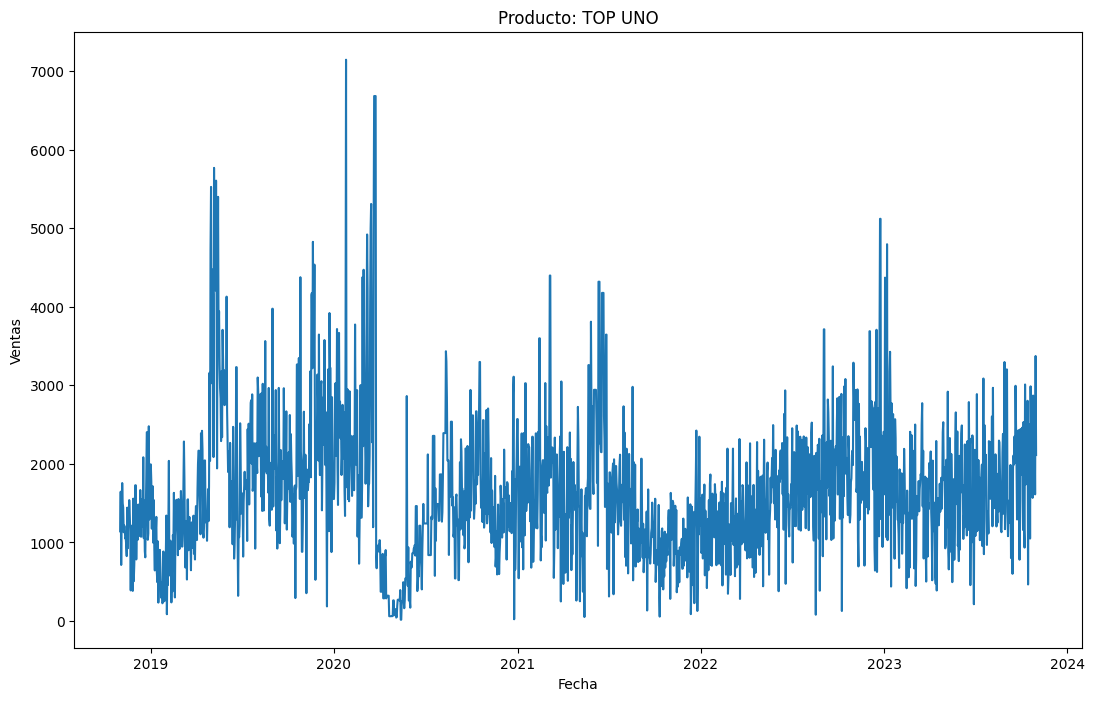

In [ ]:
figure(figsize=(13, 8))
# Crear un gráfico de líneas para cada producto
plot(df_todas_fechas_hasta_nov['FechaMovimiento'], df_todas_fechas_hasta_nov['MontoBase'], label=df_todas_fechas_hasta_nov['NombreProducto'])
title(f'Producto: TOP UNO')
xlabel('Fecha')
ylabel('Ventas')
show()

## Metricas de Evaluación


In [ ]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = where(y_true != 0)
        y_true, y_pred = array(y_true)[non_zero_indices], array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, nan)
            return nan

        # Calcular MAPE solo para los valores válidos
        return mean(abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'NombreProducto',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)

df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

  FechaMovimiento  MontoBase
0      2023-11-01  1999.7321
1      2023-11-02  1011.2892
2      2023-11-03  2343.7883
3      2023-11-04  1673.2089
4      2023-11-05  1181.9289
5      2023-11-06   863.7984
6      2023-11-07  1648.4580
7      2023-11-08  1434.6711
8      2023-11-09  1680.6493
9      2023-11-10  1767.7892
FechaMovimiento    datetime64[ns]
MontoBase                 float64
dtype: object
(29, 2)


# PROPHET


### Preparado de los DataFrame

In [ ]:
## Sumar las ventas por día en df_noviembre
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todas_fechas_hasta_nov['FechaMovimiento'] = df_todas_fechas_hasta_nov['FechaMovimiento'].dt.date

# se suman todas las ventas por dia
df_noviembre_prophet = df_noviembre.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
# df_todo_hasta_nov_prophet = df_todo_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_prophet = df_todas_fechas_hasta_nov.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

df_noviembre_prophet = df_noviembre_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo_hasta_nov_prophet = df_todo_hasta_nov_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)
print("----Prophet----")
print(df_noviembre_prophet.head)
print(df_noviembre_prophet.dtypes)
print(df_todo_hasta_nov_prophet.head)
print(df_todo_hasta_nov_prophet.dtypes)

<bound method NDFrame.head of      FechaMovimiento  NombreProducto  MontoBase
1698      2023-11-01  POLLO ESPECIAL  1999.7321
1699      2023-11-02  POLLO ESPECIAL  1011.2892
1700      2023-11-03  POLLO ESPECIAL  2343.7883
1701      2023-11-04  POLLO ESPECIAL  1673.2089
1702      2023-11-05  POLLO ESPECIAL  1181.9289
1703      2023-11-06  POLLO ESPECIAL   863.7984
1704      2023-11-07  POLLO ESPECIAL  1648.4580
1705      2023-11-08  POLLO ESPECIAL  1434.6711
1706      2023-11-09  POLLO ESPECIAL  1680.6493
1707      2023-11-10  POLLO ESPECIAL  1767.7892
1708      2023-11-11  POLLO ESPECIAL  1634.3693
1709      2023-11-12  POLLO ESPECIAL   773.2943
1710      2023-11-13  POLLO ESPECIAL  1415.9722
1711      2023-11-14  POLLO ESPECIAL  1897.6758
1712      2023-11-15  POLLO ESPECIAL  2099.2341
1713      2023-11-16  POLLO ESPECIAL  1211.0052
1714      2023-11-18  POLLO ESPECIAL  1232.0448
1715      2023-11-19  POLLO ESPECIAL   220.6310
1716      2023-11-20  POLLO ESPECIAL  1145.2787
1717      

In [ ]:
df_todo_hasta_nov['FechaMovimiento'] = to_datetime(df_todo_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])

# df_todo_hasta_nov_desde_2021 = df_todo_hasta_nov[~(df_todo_hasta_nov['FechaMovimiento'].dt.year < 2021)]
df_todo_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]

print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)

# se devuelve el tipo object a ds para prophet
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date
df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date

print("---" *10)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.dtypes)
print(df_todo_hasta_nov.shape)
print(df_todo_hasta_nov_desde_2021.head())
print(df_todo_hasta_nov_desde_2021.dtypes)
print(df_todo_hasta_nov_desde_2021.shape)

FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
    FechaMovimiento  NombreProducto  MontoBase
792      2021-01-01             NaN  2569.5190
793      2021-01-02  POLLO ESPECIAL  1822.6310
794      2021-01-03  POLLO ESPECIAL   543.4340
795      2021-01-04  POLLO ESPECIAL  1221.7920
796      2021-01-05  POLLO ESPECIAL  1963.7850
FechaMovimiento    datetime64[ns]
NombreProducto             object
MontoBase                 float64
dtype: object
------------------------------
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
FechaMovimiento     object
NombreProducto      object
MontoBase          float64
dtype: object
(1698, 3)
    FechaMovimiento  NombreProducto  MontoBase
792      2021-01-01             NaN  2569.5190
793      2021-01-02  POLLO ESPECIAL  1822.6310
794      2021-01-03

<ipython-input-19-27d94f352119>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo_hasta_nov_desde_2021['FechaMovimiento'] = df_todo_hasta_nov_desde_2021['FechaMovimiento'].dt.date


In [ ]:
# #primero cambiamos la columna ds a datatime
# df_noviembre['ds'] = to_datetime(df_noviembre['ds'])
# df_todo_hasta_nov['ds'] = to_datetime(df_todo_hasta_nov['ds'])
# # se quitan las horas de la columna de tiempo
# df_noviembre['ds'] = df_noviembre['ds'].dt.date
# df_todo_hasta_nov['ds'] = df_todo_hasta_nov['ds'].dt.date
# se suman todas las ventas por dia

df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()
df_todo_hasta_nov_desde_2021_prophet = df_todo_hasta_nov_desde_2021_prophet.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})

print(df_todo_hasta_nov_desde_2021_prophet.head)
print(df_todo_hasta_nov_desde_2021_prophet.shape)

<bound method NDFrame.head of               ds         y
0     2021-01-01 2569.5190
1     2021-01-02 1822.6310
2     2021-01-03  543.4340
3     2021-01-04 1221.7920
4     2021-01-05 1963.7850
...          ...       ...
1029  2023-10-27 2152.1624
1030  2023-10-28 2499.2891
1031  2023-10-29 1611.2471
1032  2023-10-30 3372.2990
1033  2023-10-31 2112.0323

[1034 rows x 2 columns]>
(1034, 2)


## Predicciones con todos los datos y desde 2021 del producto top 1

este producto esta en el dataframe df_top_1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kae10nn/k19k9o53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kae10nn/il_flckg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running 

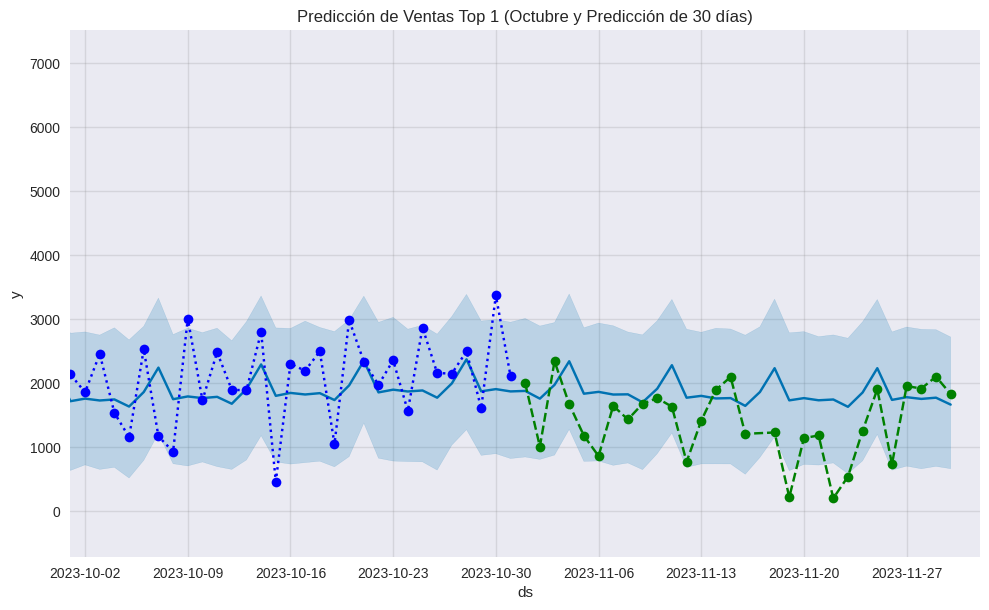

<Figure size 1600x1000 with 0 Axes>

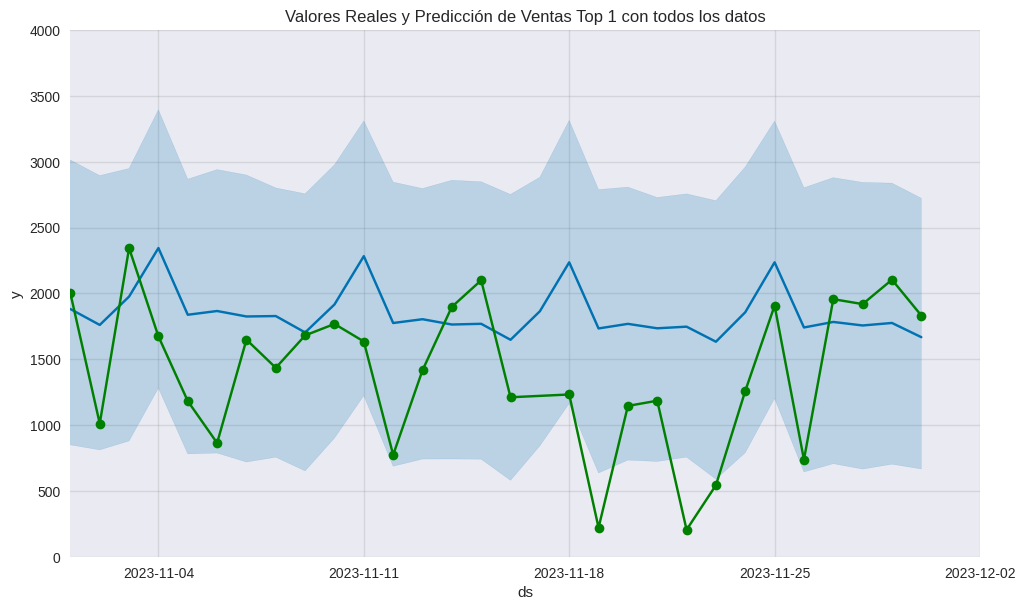

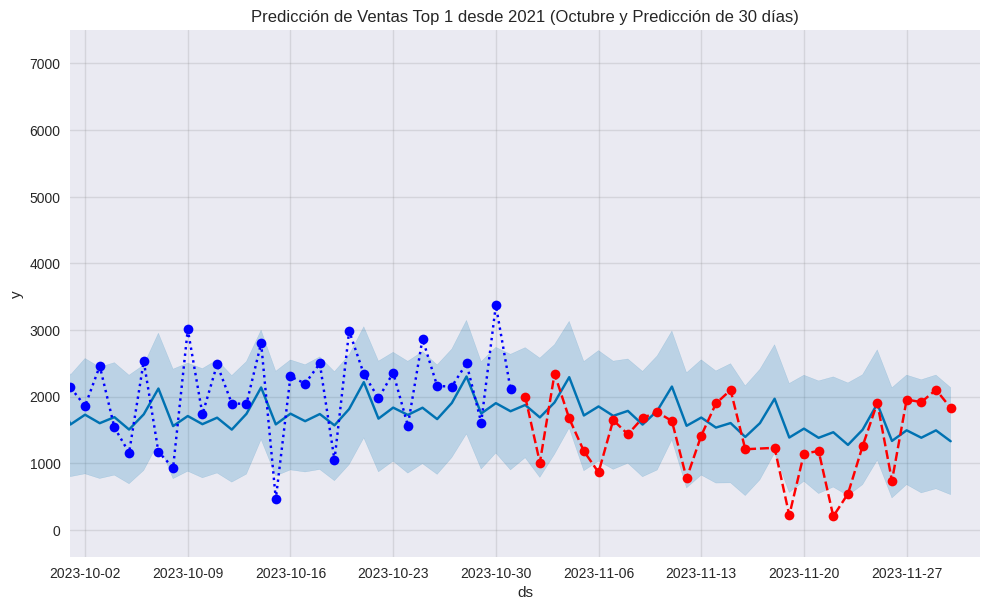

<Figure size 1600x1000 with 0 Axes>

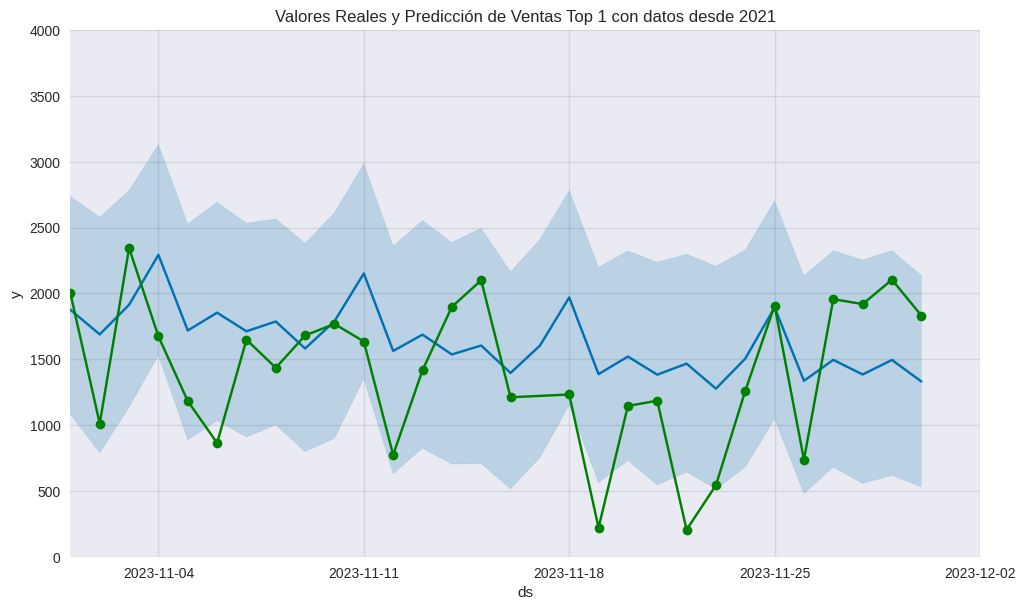

prediccion con todos los valores               ds      yhat
1826 2023-11-01 1881.0169
1827 2023-11-02 1760.1824
1828 2023-11-03 1975.6497
1829 2023-11-04 2344.3373
1830 2023-11-05 1837.4994
1831 2023-11-06 1866.0010
1832 2023-11-07 1824.4606
1833 2023-11-08 1827.6630
1834 2023-11-09 1703.0299
1835 2023-11-10 1915.6662
1836 2023-11-11 2282.5336
1837 2023-11-12 1774.9089
1838 2023-11-13 1803.6594
1839 2023-11-14 1763.3858
1840 2023-11-15 1768.8366
1841 2023-11-16 1647.3792
1842 2023-11-17 1864.0493
1843 2023-11-18 2235.7254
1844 2023-11-19 1733.5909
1845 2023-11-20 1768.4111
1846 2023-11-21 1734.6800
1847 2023-11-22 1747.0362
1848 2023-11-23 1632.7381
1849 2023-11-24 1856.7145
1850 2023-11-25 2235.7431
1851 2023-11-26 1740.9130
1852 2023-11-27 1782.9050
1853 2023-11-28 1756.1383
1854 2023-11-29 1775.1885
1855 2023-11-30 1667.2625
prediccion sin el 2020               ds      yhat
1034 2023-11-01 1875.0166
1035 2023-11-02 1688.5578
1036 2023-11-03 1913.3475
1037 2023-11-04 2292.4028
1038 2

In [ ]:
# definir las fechas de inicio y fin
fecha_inicio_str = '2023-10-01'
fecha_fin_str = '2023-12-02'
fecha_inicio_nov_str = '2023-11-01'
# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')
fecha_inicio_nov = datetime.strptime(fecha_inicio_nov_str, '%Y-%m-%d')

# Crear un modelo de Prophet
modelo1 = Prophet()
modelo2 = Prophet()
# Ajustar el modelo con los datos de entrenamiento
modelo1.fit(df_todo_hasta_nov_prophet)
modelo2.fit(df_todo_hasta_nov_desde_2021_prophet)
# Crear un DataFrame con fechas futuras para hacer la predicción
futuro1 = modelo1.make_future_dataframe(periods=30)
futuro2 = modelo2.make_future_dataframe(periods=30)
# Hacer la predicción
prediccion1 = modelo1.predict(futuro1)
prediccion2 = modelo2.predict(futuro2)

# Visualizar la predicción con límites ajustados
fig = modelo1.plot(prediccion1)

plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')

# Aplicar límites al eje x
xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
title(f'Predicción de Ventas Top 1 (Octubre y Predicción de 30 días)')
# Mostrar el gráfico
show()

figure(figsize=(16, 10))
fig = modelo1.plot(prediccion1)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con todos los datos')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,4000])
show()

# Visualizar la predicción con límites ajustados
fig = modelo2.plot(prediccion2)

plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='red', marker='o', linestyle='dashed')
plot(df_todo_hasta_nov_prophet['ds'], df_todo_hasta_nov_prophet['y'], label='Ventas reales de noviembre', color='blue', marker='o', linestyle='dotted')

# Aplicar límites al eje x
xlim([fecha_inicio, fecha_fin])
# Añadir título al gráfico
title(f'Predicción de Ventas Top 1 desde 2021 (Octubre y Predicción de 30 días)')
# Mostrar el gráfico
show()

figure(figsize=(16, 10))
fig = modelo2.plot(prediccion2)
plot(df_noviembre_prophet['ds'], df_noviembre_prophet['y'], label='Ventas reales de noviembre', color='green', marker='o')
title(f'Valores Reales y Predicción de Ventas Top 1 con datos desde 2021')
xlim([fecha_inicio_nov, fecha_fin])
ylim([0,4000])
show()

# Extraer los valores reales de predicción para cada día
valores_prediccion1 = prediccion1[['ds', 'yhat']].tail(30)
valores_prediccion2 = prediccion2[['ds', 'yhat']].tail(30)

# Mostrar el DataFrame con los valores de predicción
print("prediccion con todos los valores " , valores_prediccion1)
print("prediccion sin el 2020 " , valores_prediccion2)
# # Visualizar la predicción
# fig = modelo1.plot(prediccion1)
# show()

# fig = modelo2.plot(prediccion2)
# show()

## EVALUACION

evaluacion con todos los datos


In [ ]:
df_noviembre_sumaT = df_noviembre[[
                                    'FechaMovimiento',
                                    'MontoBase',
                                    ]]
df_noviembre_sumaT = df_noviembre_sumaT.groupby('FechaMovimiento')['MontoBase'].sum().reset_index()

print(df_noviembre_sumaT.head(10))
print(df_noviembre_sumaT.dtypes)
print(df_noviembre_sumaT.shape)



  FechaMovimiento  MontoBase
0      2023-11-01  1999.7321
1      2023-11-02  1011.2892
2      2023-11-03  2343.7883
3      2023-11-04  1673.2089
4      2023-11-05  1181.9289
5      2023-11-06   863.7984
6      2023-11-07  1648.4580
7      2023-11-08  1434.6711
8      2023-11-09  1680.6493
9      2023-11-10  1767.7892
FechaMovimiento     object
MontoBase          float64
dtype: object
(29, 2)


### Revisar si noviembre no tiene espacios vacios


In [ ]:
if len(df_noviembre_sumaT) < 30:
    # Crear un rango de fechas de noviembre
    fechas_noviembre = date_range(start='2023-11-01', end='2023-11-30', freq='D')

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns]
    df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'])

    # Crear un DataFrame con todas las fechas de noviembre
    todas_las_fechas = DataFrame({'FechaMovimiento': fechas_noviembre})

    # Merge para obtener las fechas faltantes
    df_noviembre_sumaT = todas_las_fechas.merge(df_noviembre_sumaT, on='FechaMovimiento', how='left')

    # Llenar los valores faltantes con 0
    df_noviembre_sumaT['MontoBase'].fillna(0, inplace=True)

    # Convertir la columna 'FechaMovimiento' a tipo datetime64[ns] sin tiempo
    df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'].dt.date)

    # Ordenar el DataFrame por fecha
    df_noviembre_sumaT.sort_values(by='FechaMovimiento', inplace=True)

# Asegurarse de que la longitud sea exactamente 30
assert len(df_noviembre_sumaT) == 30, "¡Error! El DataFrame no tiene 30 días."

# Imprimir el DataFrame resultante
print(df_noviembre_sumaT)

   FechaMovimiento  MontoBase
0       2023-11-01  1999.7321
1       2023-11-02  1011.2892
2       2023-11-03  2343.7883
3       2023-11-04  1673.2089
4       2023-11-05  1181.9289
5       2023-11-06   863.7984
6       2023-11-07  1648.4580
7       2023-11-08  1434.6711
8       2023-11-09  1680.6493
9       2023-11-10  1767.7892
10      2023-11-11  1634.3693
11      2023-11-12   773.2943
12      2023-11-13  1415.9722
13      2023-11-14  1897.6758
14      2023-11-15  2099.2341
15      2023-11-16  1211.0052
16      2023-11-17     0.0000
17      2023-11-18  1232.0448
18      2023-11-19   220.6310
19      2023-11-20  1145.2787
20      2023-11-21  1184.8036
21      2023-11-22   204.6555
22      2023-11-23   543.1047
23      2023-11-24  1259.1186
24      2023-11-25  1906.8695
25      2023-11-26   736.9200
26      2023-11-27  1955.9174
27      2023-11-28  1918.5018
28      2023-11-29  2103.6930
29      2023-11-30  1831.7624


In [ ]:
# print(df_noviembre_sumaT.dtypes)

copiar el dataframe de noviembre

In [ ]:
df_noviembre_desde_2021 = df_noviembre_sumaT.copy()

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_sumaT['FechaMovimiento'] = to_datetime(df_noviembre_sumaT['FechaMovimiento'])
valores_prediccion1['ds'] = to_datetime(valores_prediccion1['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_sumaT = merge(df_noviembre_sumaT, valores_prediccion1[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_sumaT.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_sumaT.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_sumaT.head(50))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  1999.7321       1881.0169
1       2023-11-02  1011.2892       1760.1824
2       2023-11-03  2343.7883       1975.6497
3       2023-11-04  1673.2089       2344.3373
4       2023-11-05  1181.9289       1837.4994
5       2023-11-06   863.7984       1866.0010
6       2023-11-07  1648.4580       1824.4606
7       2023-11-08  1434.6711       1827.6630
8       2023-11-09  1680.6493       1703.0299
9       2023-11-10  1767.7892       1915.6662
10      2023-11-11  1634.3693       2282.5336
11      2023-11-12   773.2943       1774.9089
12      2023-11-13  1415.9722       1803.6594
13      2023-11-14  1897.6758       1763.3858
14      2023-11-15  2099.2341       1768.8366
15      2023-11-16  1211.0052       1647.3792
16      2023-11-17     0.0000       1864.0493
17      2023-11-18  1232.0448       2235.7254
18      2023-11-19   220.6310       1733.5909
19      2023-11-20  1145.2787       1768.4111
20      2023-11-21  1184.8036     

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 579555.4652933188
MAE is : 606.2327973754228
R2 is : -0.5956893957885148 %
------------------------------
MRSE is : 761.2854033102952
MAPE is : 92.2632432603097 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion sin 2020

In [ ]:
# Convertir las columnas de fecha a tipo datetime
df_noviembre_desde_2021['FechaMovimiento'] = to_datetime(df_noviembre_desde_2021['FechaMovimiento'])
valores_prediccion2['ds'] = to_datetime(valores_prediccion2['ds'])

# Fusionar los DataFrames en base a la columna de fecha
df_noviembre_desde_2021 = merge(df_noviembre_desde_2021, valores_prediccion2[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

# Renombrar la columna yhat a Ventas_PROPHET
df_noviembre_desde_2021.rename(columns={'yhat': 'Ventas_PROPHET'}, inplace=True)

# Opcional: Eliminar la columna adicional 'ds' si no la necesitas
df_noviembre_desde_2021.drop(columns=['ds'], inplace=True)

# Imprimir el resultado
print(df_noviembre_desde_2021.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET
0       2023-11-01  1999.7321       1875.0166
1       2023-11-02  1011.2892       1688.5578
2       2023-11-03  2343.7883       1913.3475
3       2023-11-04  1673.2089       2292.4028
4       2023-11-05  1181.9289       1717.8459
5       2023-11-06   863.7984       1853.3157
6       2023-11-07  1648.4580       1712.0499
7       2023-11-08  1434.6711       1786.3423
8       2023-11-09  1680.6493       1581.1540
9       2023-11-10  1767.7892       1788.3776
10      2023-11-11  1634.3693       2151.4295
11      2023-11-12   773.2943       1562.8089
12      2023-11-13  1415.9722       1686.5002
13      2023-11-14  1897.6758       1536.0469
14      2023-11-15  2099.2341       1604.0007
15      2023-11-16  1211.0052       1395.5271
16      2023-11-17     0.0000       1602.6629
17      2023-11-18  1232.0448       1968.9060
18      2023-11-19   220.6310       1386.7700
19      2023-11-20  1145.2787       1520.1870


In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])

Evaluation metric results:  
MSE is : 404699.6264897243
MAE is : 518.9080188342975
R2 is : -0.11425901598976829 %
------------------------------
MRSE is : 636.1600635765533
MAPE is : 73.55546727342478 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




# LSTM


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler

In [ ]:
df_todas_fechas_hasta_nov['FechaMovimiento'] = to_datetime(df_todas_fechas_hasta_nov['FechaMovimiento'])
df_todas_fechas_hasta_nov_desde_2021 = df_todas_fechas_hasta_nov[~(df_todas_fechas_hasta_nov['FechaMovimiento'].dt.year < 2021)]

##Todos los Datos

In [ ]:
# df_lstm = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

# df_lstm_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

df_lstm = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021 =df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]

In [ ]:
# Seleccionar las columnas relevantes y convertir 'FechaMovimiento' a tipo datetime
df_lstm = df_lstm[['FechaMovimiento', 'MontoBase']]
df_lstm['FechaMovimiento'] = to_datetime(df_lstm['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_lstm.set_index('FechaMovimiento', inplace=True)

# Ordenar el DataFrame por la fecha
df_lstm.sort_index(inplace=True)

# Muestra el DataFrame resultante
print(df_lstm)

                 MontoBase
FechaMovimiento           
2018-11-01       1140.6240
2018-11-02       1645.2540
2018-11-03        712.9790
2018-11-04       1343.6330
2018-11-05       1755.2580
...                    ...
2023-10-27       2152.1624
2023-10-28       2499.2891
2023-10-29       1611.2471
2023-10-30       3372.2990
2023-10-31       2112.0323

[1826 rows x 1 columns]


In [ ]:
# print(df_lstm)
# print(df_lstm.dtypes)
# print(df_todo_hasta_nov_prophet)
# print(df_todo_hasta_nov_prophet.dtypes)

In [ ]:
df_lstm.describe()
#df_lstm.head

,MontoBase
count,1826.0000
mean,1670.9849
std,902.3210
min,15.9310
25%,1090.8285
50%,1552.1155
75%,2112.3193
max,7142.9620


In [ ]:
# Crear un objeto RobustScaler
scaler = RobustScaler()
df_lstm['MontoBase_robust_scaler'] = scaler.fit_transform(df_lstm['MontoBase'].values.reshape(-1, 1))

# Función para crear secuencias con predicciones
def create_dataset_with_preds(X, y, pred_steps, v_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - v_time_steps - pred_steps):
        v = X[i:(i + v_time_steps)].reshape((v_time_steps, 1))
        Xs.append(v)
        ys.append(y[i + v_time_steps + pred_steps - 1])
    return array(Xs), array(ys)

# Función para crear conjuntos de entrenamiento y prueba con predicciones
def create_sequences_dwp(data_escalada, pred_steps, time_steps):
    X_data, y_data = create_dataset_with_preds(data_escalada, data_escalada, pred_steps, time_steps)
    return X_data, y_data

seq_length = 30  # esto tambien es la cantidad de predicciones que queremos
# X, y = create_sequences_1(df_lstm['MontoBase_scaler'].values, seq_length)
X, y = create_sequences_dwp(df_lstm['MontoBase_robust_scaler'].values, seq_length, 30)

dividir en entrenamiento y al final toda la prueba

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 31)
# train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dividir en periodos de testeo en medio de la serie temporal

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(n_splits=5)  # Puedes ajustar el número de divisiones

# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [ ]:
# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1735, 30, 1)
(1735,)


In [ ]:
# Construir el modelo LSTM
model = Sequential()

# model.add(LSTM(units = 300, return_sequences = False, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

# # 2º capa LSTM y Dropout para regularización.
# model.add(LSTM(units = 100, return_sequences = True))
# model.add(Dropout(rate=0.2))

# 3º capa LSTM y Dropout para regularización.
model.add(LSTM(units = 200, return_sequences = False))
model.add(Dropout(rate=0.2))

# Capa de Salida!
model.add(Dense(units = 100, activation='relu'))
model.add(Dense(units = 1))

# Resumen del modelo!
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=80, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(predictions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 502601 (1.92 MB)
Trainable params: 502601 

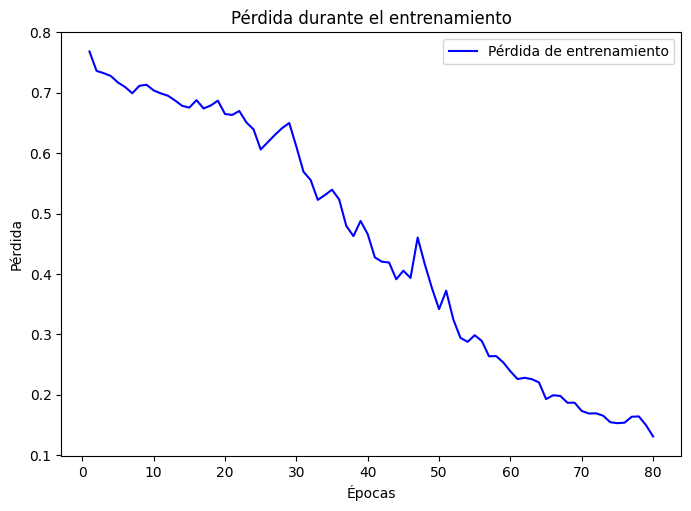

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5.5))
plot(epochs, loss, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

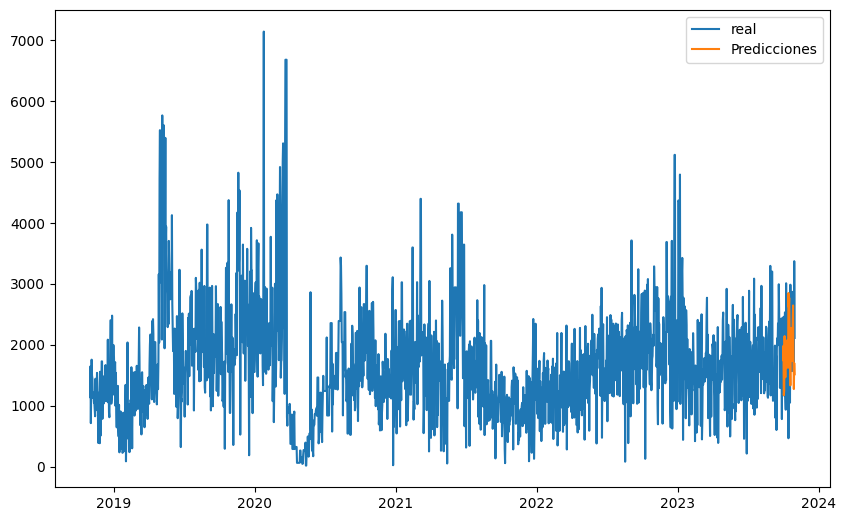

In [ ]:
longitud_predicciones = len(predictions)
# Visualizar las predicciones
figure(figsize=(10, 6.2))
plot(df_lstm['MontoBase'], label='real')
plot(df_lstm.index[-longitud_predicciones:], predictions.flatten(), label='Predicciones')
legend()
show()

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (1766, 30, 1)
Forma de y: (1766,)


1/1 [==============================] - 0s 108ms/step


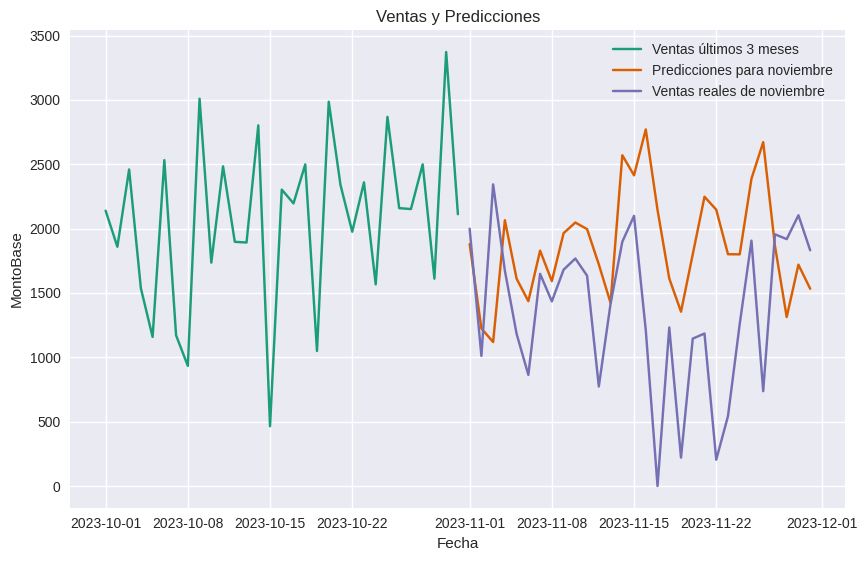

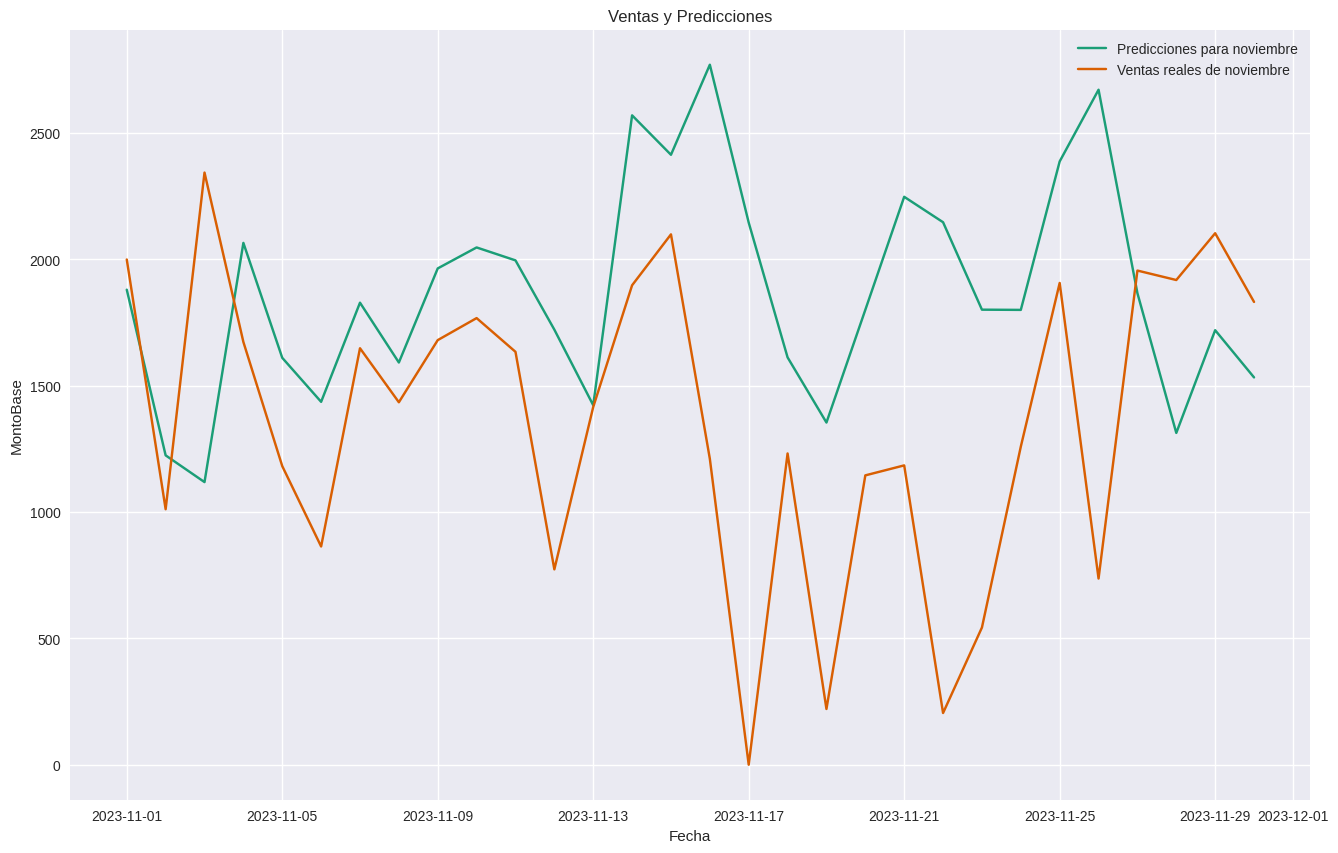

In [ ]:
# convertir a datetime el indice, que era la columna FechaMovimiento
df_lstm.index = to_datetime(df_lstm.index)

# Preparar datos de entrada para las predicciones
last_3_months = df_lstm[df_lstm.index >= '2023-10-01']  # Este rango de meses es para graficar pocos datos
last_days = df_lstm.tail(90)
# last_days = df_lstm.tail(60)  # elegimos los ultimos valores para obtener la prediccion

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Hacer predicciones para los siguientes 30 días
predictions_future = model.predict(input_data)

# Desnormalizar las predicciones
predictions_future = scaler.inverse_transform(predictions_future)

# Visualizar los resultados
figure(figsize=(10, 6.2))

# Datos de ventas de los últimos 3 meses
plot(last_3_months.index, last_3_months['MontoBase'], label='Ventas último mes')

# Predicciones para noviembre de 2023
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(16, 10))
dates_future = date_range(start='2023-11-01', periods=len(predictions_future))
plot(dates_future, predictions_future, label='Predicciones para noviembre')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
# xticks(rotation=20)
show()

In [ ]:
# last_3_months.shape
print(predictions_future.shape)

(30, 1)


### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_sumaT['Ventas_LSTM'] = predictions_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  1999.7321       1881.0169    1982.0237
1       2023-11-02  1011.2892       1760.1824    1171.5325
2       2023-11-03  2343.7883       1975.6497    1247.8290
3       2023-11-04  1673.2089       2344.3373    2142.0935
4       2023-11-05  1181.9289       1837.4994    1705.3453
5       2023-11-06   863.7984       1866.0010    1466.1659
6       2023-11-07  1648.4580       1824.4606    1860.9314
7       2023-11-08  1434.6711       1827.6630    1614.3976
8       2023-11-09  1680.6493       1703.0299    2051.5815
9       2023-11-10  1767.7892       1915.6662    2069.9138
10      2023-11-11  1634.3693       2282.5336    2033.4506
11      2023-11-12   773.2943       1774.9089    1742.6033
12      2023-11-13  1415.9722       1803.6594    1622.1105
13      2023-11-14  1897.6758       1763.3858    2849.3928
14      2023-11-15  2099.2341       1768.8366    2616.8547
15      2023-11-16  1211.0052       1647.3792    2770.21

In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 832099.0660667937
MAE is : 717.7978252864581
R2 is : -1.2910174012358087 %
------------------------------
MRSE is : 912.1946426431114
MAPE is : 100.21755827874483 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




**RESULTADOS**▶

Datos desde Noviembre de Prophet
train_size = int(len(X) - 31)
2 neuronas 200, Dense units = 100, dropOut = 0.1
epochs=75, batch_size=30
- loss: 0.1986
- MRSE is : 997.2112446016664
- MAPE is : 120.64469885853602 %
___
Datos desde Noviembre de Prophet
train_size = int(len(X) - 31)
2 neuronas 200, Dense units = 100, dropOut = 0.2
epochs=75, batch_size=30
- loss: 0.1852
- MRSE is : 845.4700605597287
- MAPE is : 104.17522899801234 %
___

---


## DESDE 2021

In [ ]:
df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
df_lstm_desde_2021['FechaMovimiento'] = to_datetime(df_lstm_desde_2021['FechaMovimiento'])
# df_lstm_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_lstm_desde_2021)

# Normalizar los datos
df_lstm_desde_2021['MontoBase_scaler'] = scaler.fit_transform(df_lstm_desde_2021['MontoBase'].values.reshape(-1, 1))

seq_length = 30  # ajusta según tus necesidades
X, y = create_sequences_dwp(df_lstm_desde_2021['MontoBase_scaler'].values, seq_length, 30)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) - 31)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para el modelo LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# # Construir el modelo LSTM
# model_2 = Sequential()
# model_2.add(LSTM(units=500, input_shape=(X_train.shape[1], X_train.shape[2])))

# Construir el modelo LSTM
model_2 = Sequential()
# 1º capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model_2.add(Dropout(rate=0.15))

# # 2º capa LSTM y Dropout para regularización.
# model_2.add(LSTM(units = 100, return_sequences = True))
# model_2.add(Dropout(rate=0.1))

# 3ºa capa LSTM y Dropout para regularización.
model_2.add(LSTM(units = 200, return_sequences = False))
model_2.add(Dropout(rate=0.15))

# Capa de Salida!
model_2.add(Dense(units = 100, activation='relu'))
model_2.add(Dense(units = 1))
# Resumen del modelo!
model_2.summary()
model_2.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history_2 = model_2.fit(X_train, y_train, epochs=90, batch_size=30, verbose=1)

# Hacer predicciones en el conjunto de prueba
predictions_2 = model_2.predict(X_test)

# Desnormalizar las predicciones
predictions_2 = scaler.inverse_transform(predictions_2)

     FechaMovimiento  MontoBase
792       2021-01-01  2569.5190
793       2021-01-02  1822.6310
794       2021-01-03   543.4340
795       2021-01-04  1221.7920
796       2021-01-05  1963.7850
...              ...        ...
1821      2023-10-27  2152.1624
1822      2023-10-28  2499.2891
1823      2023-10-29  1611.2471
1824      2023-10-30  3372.2990
1825      2023-10-31  2112.0323

[1034 rows x 2 columns]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 200)           161600    
                                                                 
 dropout_2 (Dropout)         (None, 30, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_3 (Dropout)         (None, 200) 

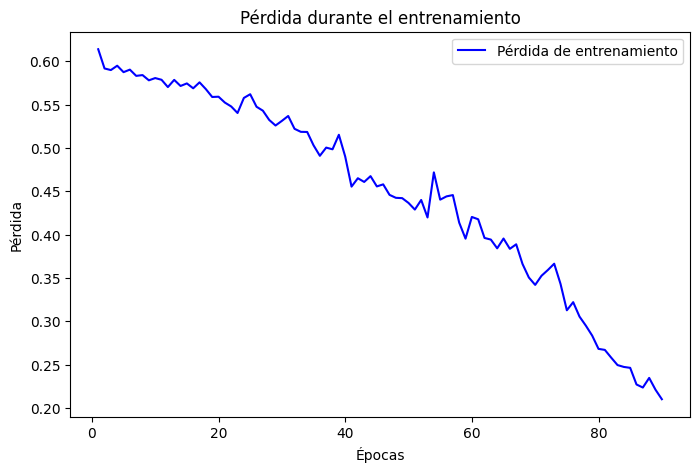

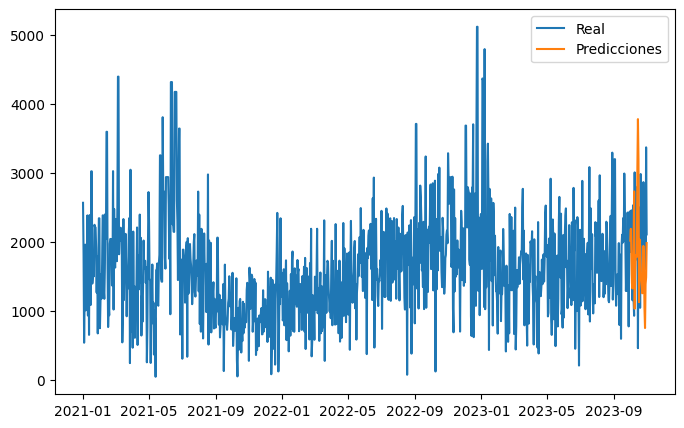

In [ ]:
# Recuperar la función de pérdida durante el entrenamiento
loss_2 = history_2.history['loss']
epochs_2 = range(1, len(loss_2) + 1)

# Graficar la pérdida durante el entrenamiento
figure(figsize=(8, 5))
plot(epochs_2, loss_2, 'b', label='Pérdida de entrenamiento')
title('Pérdida durante el entrenamiento')
xlabel('Épocas')
ylabel('Pérdida')
legend()
show()

# Crear un rango de fechas para las predicciones
fechas_predicciones = date_range(start='2023-10-01', periods=len(predictions_2))

# Visualizar las predicciones
figure(figsize=(8, 5))
plot(df_lstm_desde_2021['FechaMovimiento'], df_lstm_desde_2021['MontoBase'], label='Real')
plot(fechas_predicciones, predictions_2.flatten(), label='Predicciones')
legend()
show()


Forma de X: (974, 30, 1)
Forma de y: (974,)
1/1 [==============================] - 0s 107ms/step


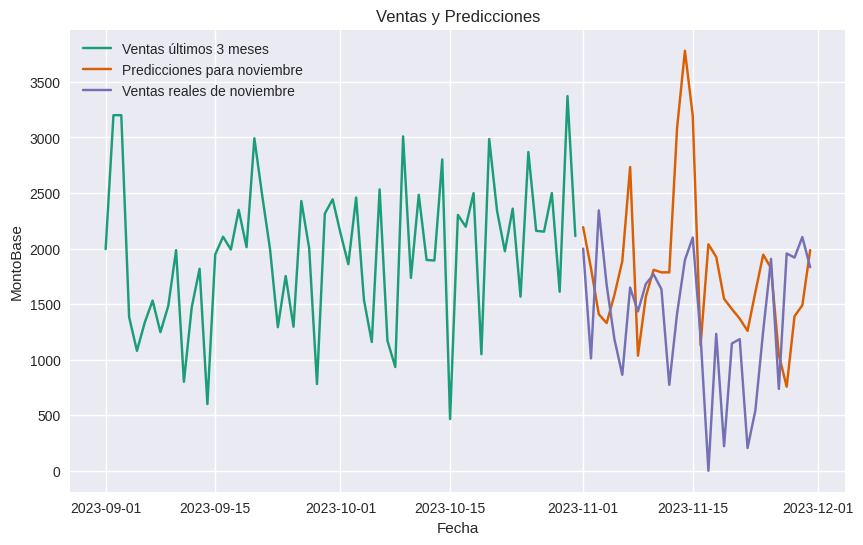

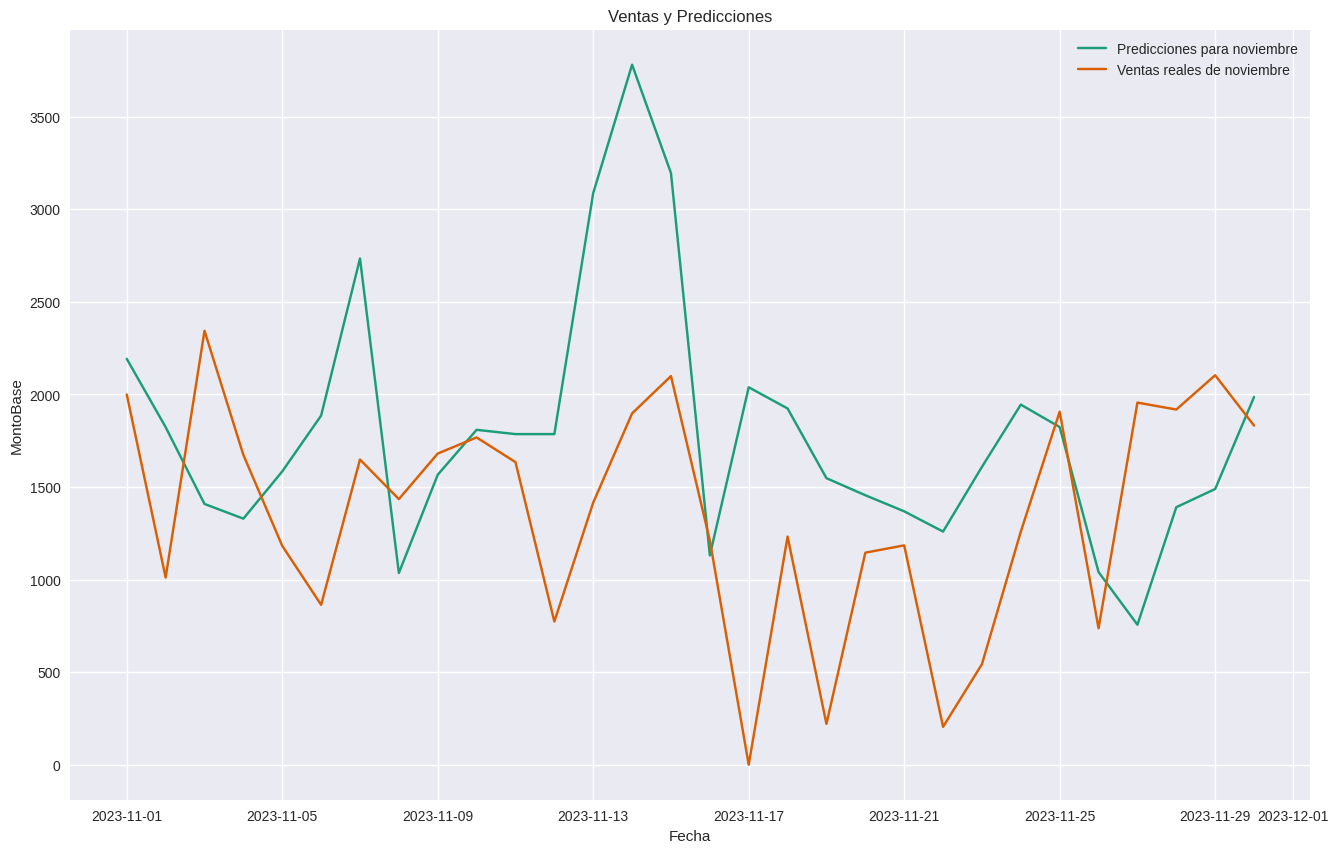

In [ ]:
# Verificar la forma de los datos
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

# df_lstm_desde_2021.index = to_datetime(df_lstm_desde_2021.index)

# Preparar datos de entrada para las predicciones
last_3_months = df_lstm_desde_2021[df_lstm_desde_2021['FechaMovimiento'] >= '2023-09-01']   # Este rango de meses es para graficar pocos datos
last_days = df_lstm.tail(90)  # elegimos los ultimos valores para obtener la prediccion

input_data = last_days['MontoBase'].values
input_data = scaler.transform(input_data.reshape(-1, 1))
# input_data, _ = create_sequences(input_data, seq_length)
input_data, _ = create_sequences_dwp(input_data, seq_length, 30)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))

# Hacer predicciones para los siguientes 30 días
predictions_2_future = model_2.predict(input_data)

# Desnormalizar las predicciones
predictions_2_future = scaler.inverse_transform(predictions_2_future)

# Visualizar los resultados
figure(figsize=(10, 6))

# Datos de ventas de los últimos 3 meses
plot(last_3_months['FechaMovimiento'], last_3_months['MontoBase'], label='Ventas últimos 3 meses')

# Predicciones para noviembre de 2023
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
show()

figure(figsize=(16, 10))
dates_future = date_range(start='2023-11-01', periods=len(predictions_2_future))
plot(dates_future, predictions_2_future, label='Predicciones para noviembre')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='Ventas reales de noviembre')
title('Ventas y Predicciones')
xlabel('Fecha')
ylabel('MontoBase')
legend()
# xticks(rotation=20)
show()

In [ ]:
# df_lstm_desde_2021 = df_lstm_desde_2021[['FechaMovimiento', 'MontoBase']]
# df_lstm_desde_2021['FechaMovimiento'] = to_datetime(df_lstm_desde_2021['FechaMovimiento'])
# print(df_lstm_desde_2021.dtypes)
# print(df_lstm_desde_2021.head(5))

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_LSTM'] = predictions_2_future

# Imprimir el resultado
print(df_noviembre_sumaT.head(20))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM
0       2023-11-01  1999.7321       1881.0169    1982.0237
1       2023-11-02  1011.2892       1760.1824    1171.5325
2       2023-11-03  2343.7883       1975.6497    1247.8290
3       2023-11-04  1673.2089       2344.3373    2142.0935
4       2023-11-05  1181.9289       1837.4994    1705.3453
5       2023-11-06   863.7984       1866.0010    1466.1659
6       2023-11-07  1648.4580       1824.4606    1860.9314
7       2023-11-08  1434.6711       1827.6630    1614.3976
8       2023-11-09  1680.6493       1703.0299    2051.5815
9       2023-11-10  1767.7892       1915.6662    2069.9138
10      2023-11-11  1634.3693       2282.5336    2033.4506
11      2023-11-12   773.2943       1774.9089    1742.6033
12      2023-11-13  1415.9722       1803.6594    1622.1105
13      2023-11-14  1897.6758       1763.3858    2849.3928
14      2023-11-15  2099.2341       1768.8366    2616.8547
15      2023-11-16  1211.0052       1647.3792    2770.21

In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])

Evaluation metric results:  
MSE is : 810391.2861113786
MAE is : 716.2041637792968
R2 is : -1.2312493956603023 %
------------------------------
MRSE is : 900.2173549267858
MAPE is : 84.83819872319869 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




**RESULTADOS**▶

Datos a partir de Noviembre de Prophet desde 2021
train_size = int(len(X) - 30)
2 neuronas 200, Dense units = 100, dropOut = 0.2
epochs=95, batch_size=30
- loss:  0.1276
- MRSE is : 941.19089663256
- MAPE is : 97.10130724096271 %

Datos a partir de df_todas_fechas_hasta_nov
train_size = int(len(X) - 31)
2 neuronas 200, Dense units = 100, dropOut = 0.15
epochs=90, batch_size=30
___




# ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
df_todo_hasta_nov_prophet.head()

,ds,y
0,2018-11-01,1140.6240
1,2018-11-02,1645.2540
2,2018-11-03,712.9790
3,2018-11-04,1343.6330
4,2018-11-05,1755.2580


## CON TODOS LOS AÑOS


In [ ]:
# df_arima = df_todo_hasta_nov_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })
df_arima = df_todas_fechas_hasta_nov[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima.dtypes)
print(df_arima.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2018-11-01       1140.6240
2018-11-02       1645.2540
2018-11-03        712.9790
2018-11-04       1343.6330
2018-11-05       1755.2580
...                    ...
2023-10-27       2152.1624
2023-10-28       2499.2891
2023-10-29       1611.2471
2023-10-30       3372.2990
2023-10-31       2112.0323

[1826 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MontoBase  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Identificar si los datos son estacionarios o no


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


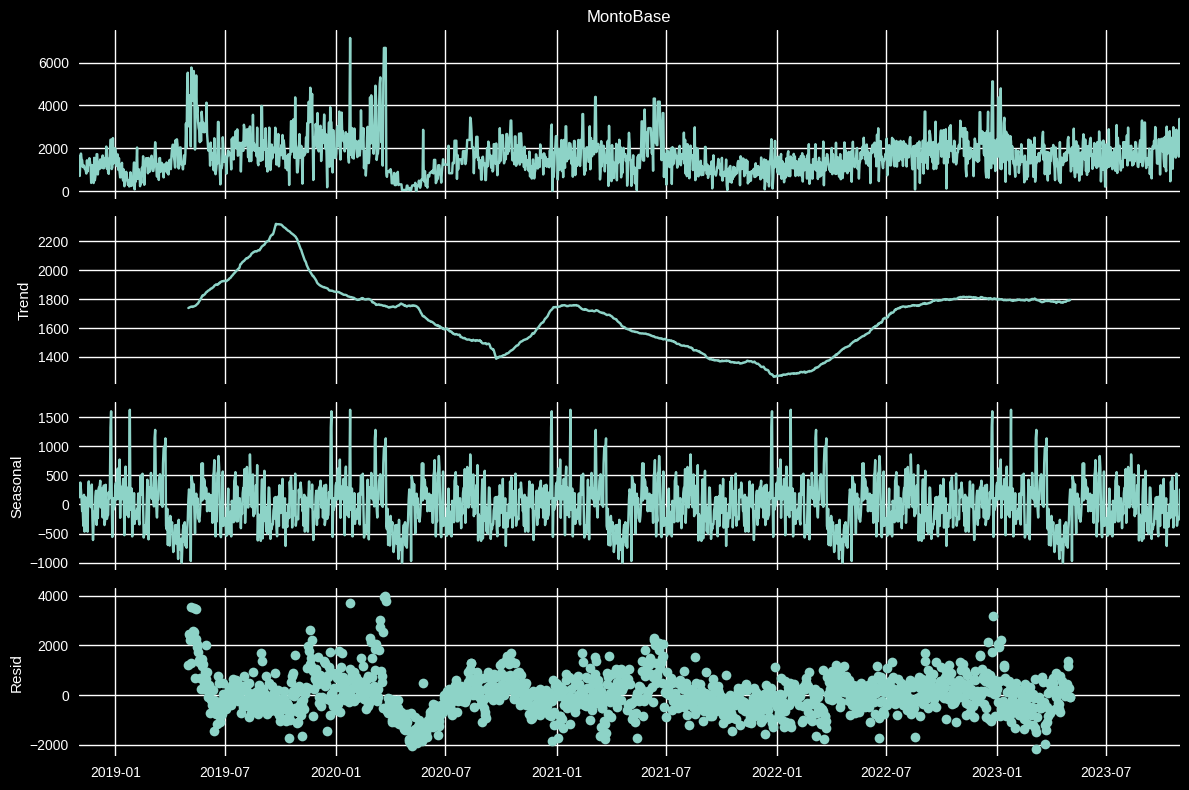

In [ ]:
#style.use('seaborn')
style.use('dark_background')
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
df_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
...,...
2023-10-27,2152.1624
2023-10-28,2499.2891
2023-10-29,1611.2471


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


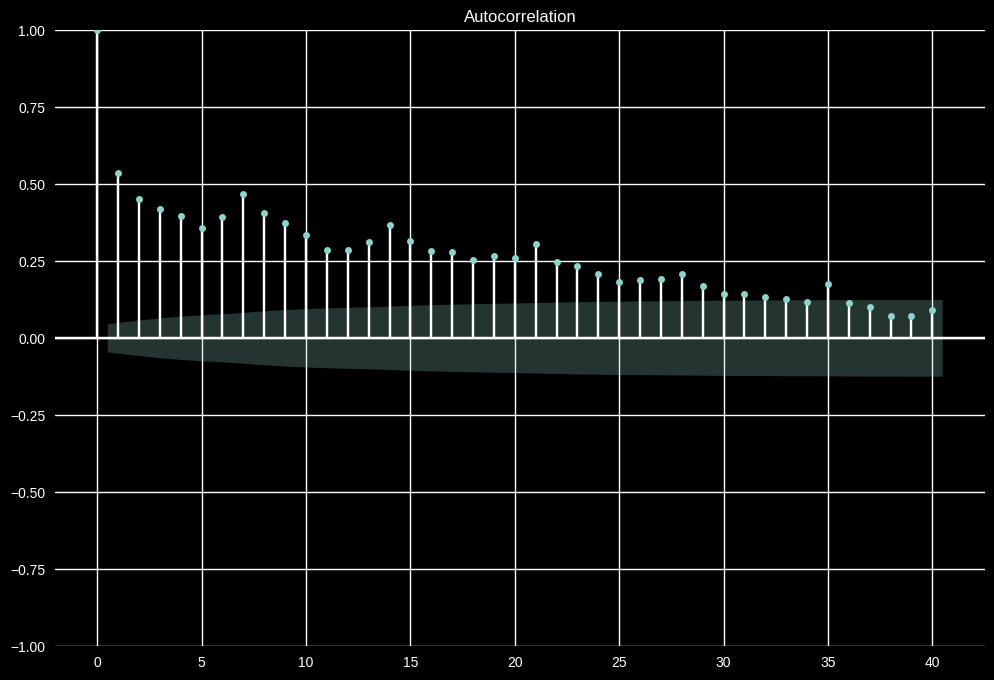

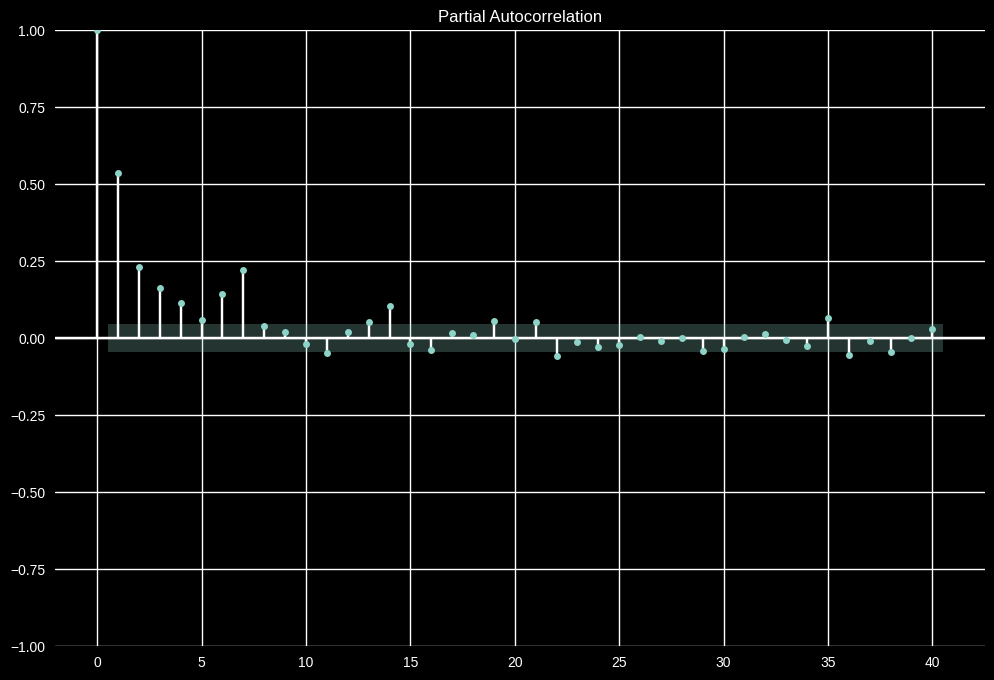

In [ ]:
# Dejar la columna 'FechaMovimiento' como tipo fecha
df_arima=df_arima.reset_index()

# Convertir 'FechaMovimiento' a tipo datetime si aún no lo has hecho
df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

# Establecer la columna de fecha como índice
df_arima.set_index('FechaMovimiento', inplace=True)

# Visualizar ACF y PACF
style.use('dark_background')
plot_acf(df_arima['MontoBase'], lags=40)
show()

plot_pacf(df_arima['MontoBase'], lags=40)
show()

### prueba de Dickey-Fuller

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


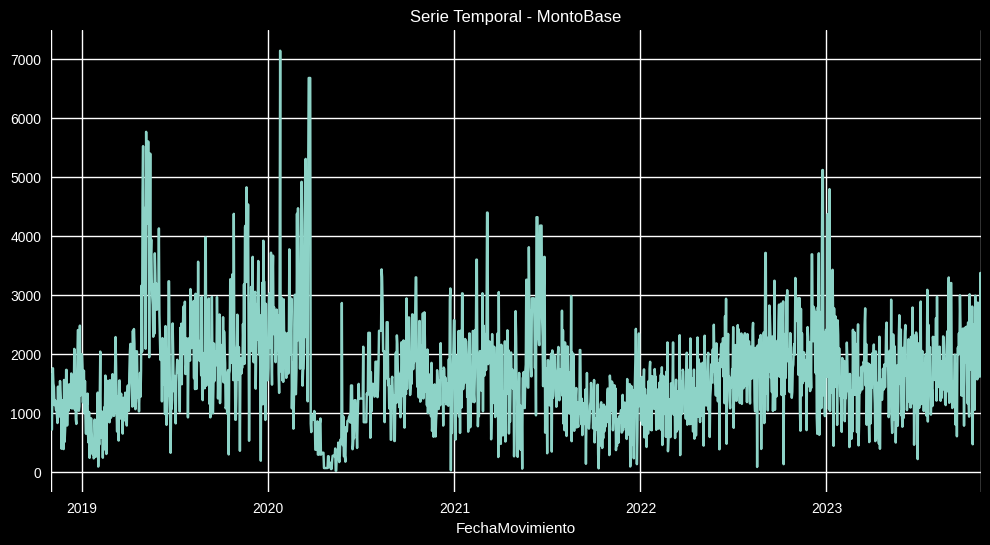

count   1826.0000
mean    1670.9849
std      902.3210
min       15.9310
25%     1090.8285
50%     1552.1155
75%     2112.3193
max     7142.9620
Name: MontoBase, dtype: float64
Estadística de la prueba de Dickey-Fuller: -4.709436133650139
P-valor: 8.078429801391406e-05
Valores críticos: {'1%': -3.4339800605797155, '5%': -2.8631434696839992, '10%': -2.5676236347535166}


In [ ]:
# 1. Visualización de la Serie Temporal
df_arima['MontoBase'].plot(figsize=(12, 6))
title('Serie Temporal - MontoBase')
show()

# 2. Estadísticas Descriptivas
print(df_arima['MontoBase'].describe())

# 3. Prueba de Dickey-Fuller
result = adfuller(df_arima['MontoBase'])
print(f'Estadística de la prueba de Dickey-Fuller: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos: {result[4]}')

In [ ]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Prueba_Dickey_Fuller(df_arima["MontoBase"],"MontoBase")

Resultados de la prueba de Dickey-Fuller para columna: MontoBase
Test Statistic                         -4.7094
p-value                                 0.0001
No Lags Used                           21.0000
Número de observaciones utilizadas   1804.0000
Critical Value (1%)                    -3.4340
Critical Value (5%)                    -2.8631
Critical Value (10%)                   -2.5676
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


### Dividir en train y test

In [ ]:
# # dividir en orden cronologico, un 80% para entrenamiento
# train_size = int(len(df_arima) * 0.8)
# train, test = df_arima[0:train_size], df_arima[train_size:]


# dividir en orden cronologico, entrenando sin el mes de octubre
train_size = int(len(df_arima) - 31)
train, test = df_arima[0:train_size], df_arima[train_size:]

# Divide los datos en entrenamiento y prueba
# # Asegúrate de tener una columna de fecha (DatetimeIndex) en tu DataFrame
# y = df_arima['MontoBase']

# # Especifica el tamaño del conjunto de entrenamiento
# train_size = len(y) - 30

# # Divide los datos en entrenamiento y prueba
# train, test = train_test_split(y, train_size=train_size)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.shape, test.shape

((1795, 1), (31, 1))

### más pruebas


In [ ]:
display(df_arima.head(10))
#df_arima = df_arima.set_index('FechaMovimiento')
df_arima = df_arima.asfreq('D')
display(df_arima.head(10))
#df_arima = df_arima.asfreq(None)

,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
2018-11-06,1496.7130
2018-11-07,1442.1560
2018-11-08,1129.0540
2018-11-09,1214.9390


,MontoBase
FechaMovimiento,
2018-11-01,1140.6240
2018-11-02,1645.2540
2018-11-03,712.9790
2018-11-04,1343.6330
2018-11-05,1755.2580
2018-11-06,1496.7130
2018-11-07,1442.1560
2018-11-08,1129.0540
2018-11-09,1214.9390


In [ ]:
print(df_arima.isnull().sum())

MontoBase    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_arima = df_arima.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test estacionariedad serie original
-------------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ADF Statistic: -4.709436133650139, p-value: 8.078429801391406e-05
KPSS Statistic: 0.19507241567080738, p-value: 0.1

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -12.599979613141564, p-value: 1.7448235624851726e-23
KPSS Statistic: 0.035725494116385176, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -16.831311400636817, p-value: 1.157376115989864e-29
KPSS Statistic: 0.052890179788375014, p-value: 0.1


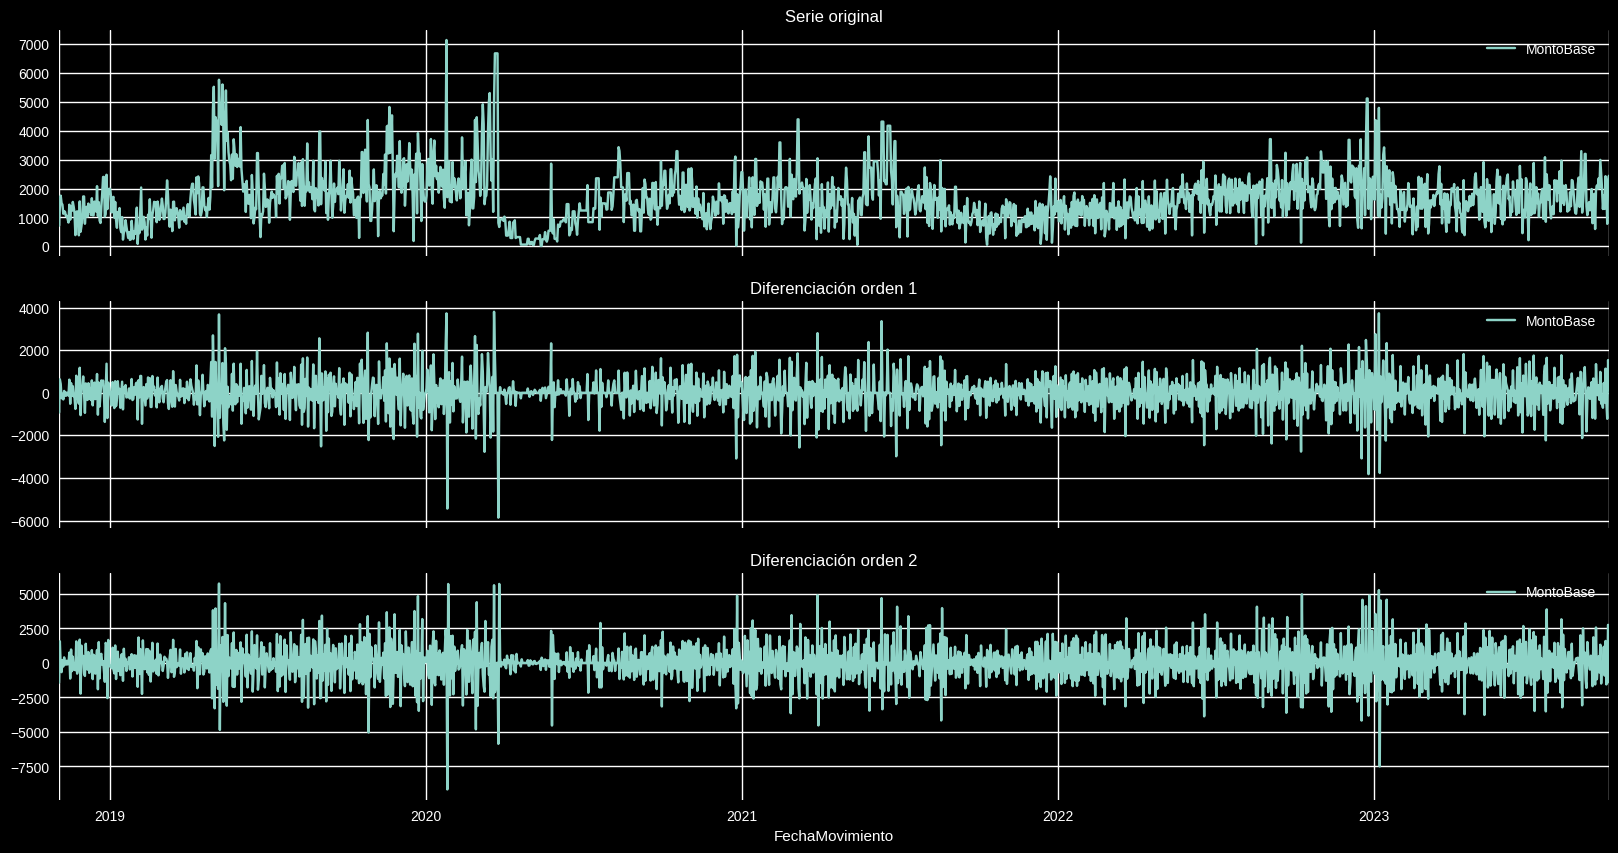

In [ ]:

from statsmodels.tsa.stattools import kpss
import warnings
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

df_arima_diff_1 = train.diff().dropna()
df_arima_diff_2 = df_arima_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df_arima)
kpss_result = kpss(df_arima)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_1)
kpss_result = kpss(df_arima.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_arima_diff_2)
kpss_result = kpss(df_arima.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
df_arima.plot(ax=axs[0], title='Serie original')
df_arima_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_arima_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


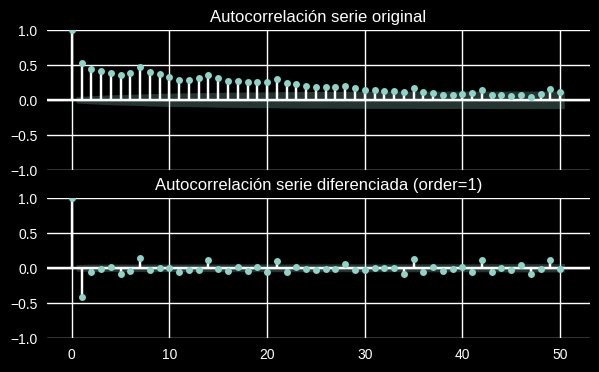

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

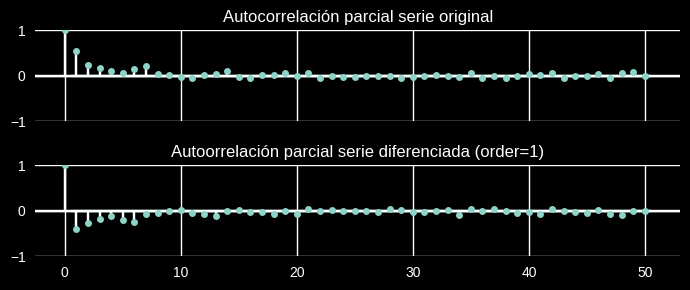

In [ ]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_arima, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_arima_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
tight_layout();

In [ ]:
# # Asegurarse de que df_arima sea una serie temporal y no un DataFrame
# #df_arima = df_arima['MontoBase']

# # Descomposición de la serie original
# res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq', period=365)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # Descomposición de la serie original y la serie diferenciada
# # ==============================================================================
# #res_decompose = seasonal_decompose(df_arima, model='additive', extrapolate_trend='freq')

# res_descompose_diff_2 = seasonal_decompose(df_arima_diff_1, model='additive', extrapolate_trend='freq', period=365)

# fig, axs = subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
# res_decompose.observed.plot(ax=axs[0, 0])
# axs[0, 0].set_title('Serie original')
# res_decompose.trend.plot(ax=axs[1, 0])
# axs[1, 0].set_title('Tendencia')
# res_decompose.seasonal.plot(ax=axs[2, 0])
# axs[2, 0].set_title('Estacionalidad')
# res_decompose.resid.plot(ax=axs[3, 0])
# axs[3, 0].set_title('Residuos')
# res_descompose_diff_2.observed.plot(ax=axs[0, 1])
# axs[0, 1].set_title('Series diferenciadas (order=1)')
# res_descompose_diff_2.trend.plot(ax=axs[1, 1])
# axs[1, 1].set_title('Tendencia')
# res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
# axs[2, 1].set_title('Estacionalidad')
# res_descompose_diff_2.resid.plot(ax=axs[3, 1])
# axs[3, 1].set_title('Residuos')
# fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
# fig.tight_layout();

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
df_arima_diff_1_12 = train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(df_arima_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(df_arima_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -13.927377313259347, p-value: 5.1635298652148855e-26
KPSS Statistic: 0.02268762317923563, p-value: 0.1


### auto_arima


In [ ]:
# # Modelo Auto-Arima
# from pmdarima import auto_arima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train,start_p=1,d=1,start_q=0,
#           max_p=5,max_d=2,max_q=6, start_P=0,
#           D=1, start_Q=0, max_P=4,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

In [ ]:
# print(modelo_auto.summary())

### implementación del modelo

In [ ]:
print(train)

                 MontoBase
FechaMovimiento           
2018-11-01       1140.6240
2018-11-02       1645.2540
2018-11-03        712.9790
2018-11-04       1343.6330
2018-11-05       1755.2580
...                    ...
2023-09-26       2428.3650
2023-09-27       2002.2241
2023-09-28        779.7913
2023-09-29       2314.3827
2023-09-30       2443.0856

[1795 rows x 1 columns]


In [ ]:
# style.use('seaborn')
# modelo_auto.plot_diagnostics(figsize=(20,8))
# show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# arima_model = SARIMAX(train["MontoBase"], order = (4,1,1), seasonal_order = (2,1,0,12)) # primerasucursal
arima_model = SARIMAX(train["MontoBase"], order = (2,1,1), seasonal_order = (2,1,0,12))
arima_result = arima_model.fit()
warnings.filterwarnings("default")
arima_result.summary()
# arima_model = SARIMAX(train["MontoBase"], order = (2,1,1), seasonal_order = (2,1,1,12)) # funciona pero es RECTA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of N

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1795
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood              -14541.933
Date:                             Mon, 18 Mar 2024   AIC                          29095.866
Time:                                     00:01:22   BIC                          29128.779
Sample:                                 11-01-2018   HQIC                         29108.022
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3476      0.016     21.745      0.000       0.316       0.379
ar.L2          0.1843      0.017     10.695      0.000       0.151       0.218
ma.L1         -0.9999      0.094    -10.589      0.000      -1.185      -0.815
ar.S.L12      -0.6634      0.019    -34.913      0.000      -0.701      -0.626
ar.S.L24      -0.3167      0.020    -16.068      0.000      -0.355      -0.278
sigma2      7.129e+05   6.74e+04     10.583      0.000    5.81e+05    8.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               389.66
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Cómo interpretar las gráficas de residuos en el modelo ARIMA


In [ ]:
arima_pred = arima_result.predict(start = len(train), end = len(df_arima)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-10-01   2293.2903
2023-10-02   2085.5822
2023-10-03   2232.0794
2023-10-04   2496.5061
2023-10-05   1145.4032
2023-10-06   1632.9114
2023-10-07   1729.6858
2023-10-08   2062.9158
2023-10-09   2380.9728
2023-10-10   1446.7614
2023-10-11   1824.6718
2023-10-12   2071.5748
2023-10-13   1966.2490
2023-10-14   2145.5950
2023-10-15   2090.8028
2023-10-16   2171.4148
2023-10-17   1097.4915
2023-10-18   1633.7606
2023-10-19   1617.5967
2023-10-20   1736.4468
2023-10-21   2121.9275
2023-10-22   1434.6610
2023-10-23   2057.2213
2023-10-24   2298.1657
2023-10-25   2104.3272
2023-10-26   2403.3535
2023-10-27   2272.5208
2023-10-28   2238.4317
2023-10-29   1185.8297
2023-10-30   1681.3809
2023-10-31   1564.6916
Freq: D, Name: ARIMA_Predictions, dtype: float64

In [ ]:
arima_pred.index = test.index

# Ahora puedes ver las predicciones con el índice correcto
print(arima_pred)

FechaMovimiento
2023-10-01   2293.2903
2023-10-02   2085.5822
2023-10-03   2232.0794
2023-10-04   2496.5061
2023-10-05   1145.4032
2023-10-06   1632.9114
2023-10-07   1729.6858
2023-10-08   2062.9158
2023-10-09   2380.9728
2023-10-10   1446.7614
2023-10-11   1824.6718
2023-10-12   2071.5748
2023-10-13   1966.2490
2023-10-14   2145.5950
2023-10-15   2090.8028
2023-10-16   2171.4148
2023-10-17   1097.4915
2023-10-18   1633.7606
2023-10-19   1617.5967
2023-10-20   1736.4468
2023-10-21   2121.9275
2023-10-22   1434.6610
2023-10-23   2057.2213
2023-10-24   2298.1657
2023-10-25   2104.3272
2023-10-26   2403.3535
2023-10-27   2272.5208
2023-10-28   2238.4317
2023-10-29   1185.8297
2023-10-30   1681.3809
2023-10-31   1564.6916
Name: ARIMA_Predictions, dtype: float64


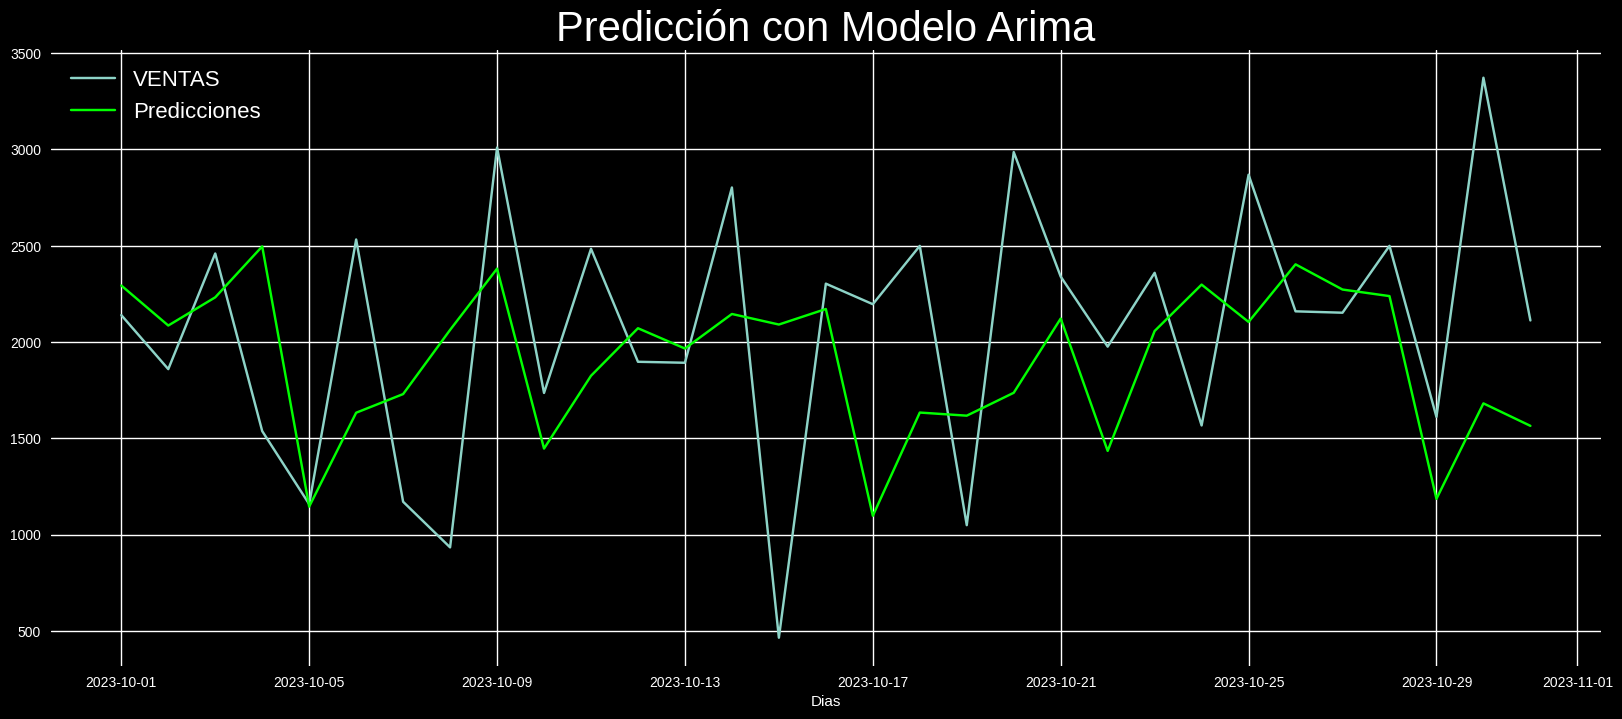

In [ ]:
style.use('dark_background')
rcParams["figure.figsize"] = (20, 8)

plot(test["MontoBase"], label="VENTAS")
plot(arima_pred, color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Dias')
ylabel('')
legend( fontsize=16);
show();

In [ ]:
arima_pred2 = arima_result.predict(start = len(df_arima), end=len(df_arima)+29, typ="levels").rename("ARIMA Predictions")
arima_pred2
# start = 1699,end=1728 # en primera sucursal
# start = 1667,end=1697 # en segunda sucursal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-11-01   2078.8731
2023-11-02   2183.9147
2023-11-03   1241.5383
2023-11-04   2068.1569
2023-11-05   2275.6165
2023-11-06   2126.4117
2023-11-07   2223.4509
2023-11-08   2206.8175
2023-11-09   2307.0399
2023-11-10   1152.5022
2023-11-11   1659.6212
2023-11-12   1645.3907
2023-11-13   1965.2135
2023-11-14   2234.9408
2023-11-15   1383.5870
2023-11-16   1997.3468
2023-11-17   2228.9072
2023-11-18   2078.1275
2023-11-19   2271.2567
2023-11-20   2202.9489
2023-11-21   2250.3996
2023-11-22   1156.7320
2023-11-23   1669.0737
2023-11-24   1618.7124
2023-11-25   1942.2573
2023-11-26   2191.5573
2023-11-27   1360.6212
2023-11-28   2050.9581
2023-11-29   2277.1359
2023-11-30   2113.2641
Freq: D, Name: ARIMA Predictions, dtype: float64

In [ ]:
print(df_noviembre_sumaT.head())
#df_noviembre_sumaT.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_sumaT.head())

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  1999.7321       1881.0169    1982.0237     2078.8731
1      2023-11-02  1011.2892       1760.1824    1171.5325     2183.9147
2      2023-11-03  2343.7883       1975.6497    1247.8290     1241.5383
3      2023-11-04  1673.2089       2344.3373    2142.0935     2068.1569
4      2023-11-05  1181.9289       1837.4994    1705.3453     2275.6165
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  1999.7321       1881.0169    1982.0237     2078.8731
1      2023-11-02  1011.2892       1760.1824    1171.5325     2183.9147
2      2023-11-03  2343.7883       1975.6497    1247.8290     1241.5383
3      2023-11-04  1673.2089       2344.3373    2142.0935     2068.1569
4      2023-11-05  1181.9289       1837.4994    1705.3453     2275.6165


In [ ]:
# Convertir el índice de las predicciones de ARIMA a un rango de fechas
fechas_prediccion = date_range(start=df_noviembre_sumaT['FechaMovimiento'].iloc[0], periods=len(arima_pred2))

# Crear un DataFrame con las fechas y las predicciones de ARIMA
df_predicciones_arima = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred2.values})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# arima_pred2.index = df_noviembre_sumaT.index
# Ahora puedes ver las predicciones con el índice correcto
print(df_predicciones_arima)

   FechaMovimiento  Ventas_ARIMA
0       2023-11-01     2078.8731
1       2023-11-02     2183.9147
2       2023-11-03     1241.5383
3       2023-11-04     2068.1569
4       2023-11-05     2275.6165
5       2023-11-06     2126.4117
6       2023-11-07     2223.4509
7       2023-11-08     2206.8175
8       2023-11-09     2307.0399
9       2023-11-10     1152.5022
10      2023-11-11     1659.6212
11      2023-11-12     1645.3907
12      2023-11-13     1965.2135
13      2023-11-14     2234.9408
14      2023-11-15     1383.5870
15      2023-11-16     1997.3468
16      2023-11-17     2228.9072
17      2023-11-18     2078.1275
18      2023-11-19     2271.2567
19      2023-11-20     2202.9489
20      2023-11-21     2250.3996
21      2023-11-22     1156.7320
22      2023-11-23     1669.0737
23      2023-11-24     1618.7124
24      2023-11-25     1942.2573
25      2023-11-26     2191.5573
26      2023-11-27     1360.6212
27      2023-11-28     2050.9581
28      2023-11-29     2277.1359
29      20

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-236-4fcfc101880d>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


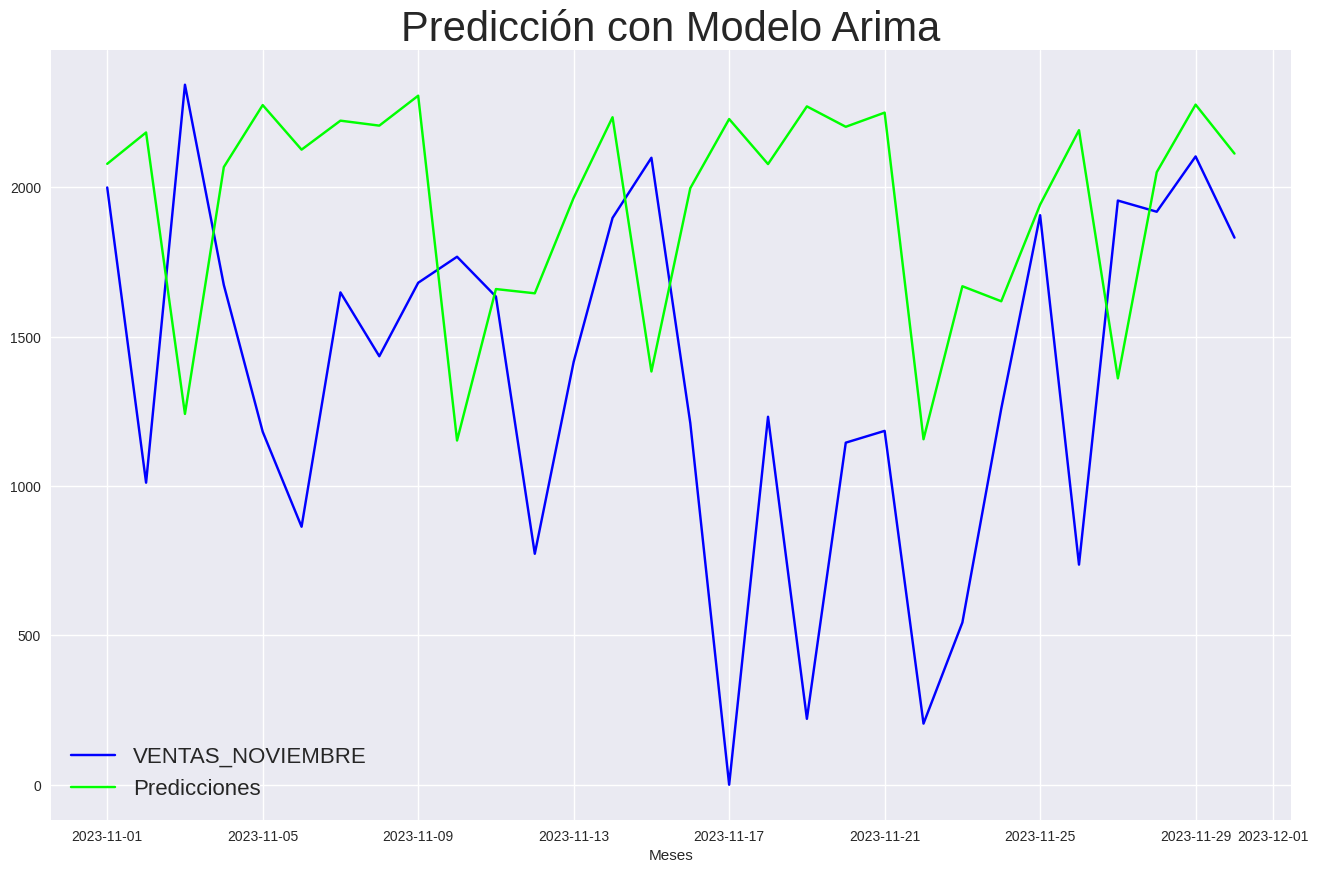

In [ ]:
style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)

#plot(test["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT["MontoBase"], color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima['FechaMovimiento'],df_predicciones_arima['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30)
xlabel('Meses')
ylabel('')
legend( fontsize=16)
show()

## Evaluar


In [ ]:
df_noviembre_sumaT['Ventas_ARIMA'] = df_predicciones_arima['Ventas_ARIMA']

print(df_noviembre_sumaT.head(10))

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  1999.7321       1881.0169    1982.0237     2078.8731
1      2023-11-02  1011.2892       1760.1824    1171.5325     2183.9147
2      2023-11-03  2343.7883       1975.6497    1247.8290     1241.5383
3      2023-11-04  1673.2089       2344.3373    2142.0935     2068.1569
4      2023-11-05  1181.9289       1837.4994    1705.3453     2275.6165
5      2023-11-06   863.7984       1866.0010    1466.1659     2126.4117
6      2023-11-07  1648.4580       1824.4606    1860.9314     2223.4509
7      2023-11-08  1434.6711       1827.6630    1614.3976     2206.8175
8      2023-11-09  1680.6493       1703.0299    2051.5815     2307.0399
9      2023-11-10  1767.7892       1915.6662    2069.9138     1152.5022


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 886419.954812642
MAE is : 777.9722920608631
R2 is : -1.4405790417212252 %
------------------------------
MRSE is : 941.4987810999237
MAPE is : 103.50424001162315 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**RESULTADOS** ▶

Con datos rellenados con valores del dia anterior
order = (0,1,2), seasonal_order = (2,1,0,12)
- MRSE is : 1270.107690496894
- MAPE is : 145.63227060419086 %

order = (1,1,2), seasonal_order = (2,1,0,12)
- MRSE is : 951.9215737767221
- MAPE is : 106.16573958343112 %

order = (2,1,2), seasonal_order = (2,1,0,12)
- MRSE is : 950.8016198272156
- MAPE is : 106.01369496156659 %

order = (3,1,2), seasonal_order = (2,1,0,12)
- MRSE is : 1280.1219862745418
- MAPE is : 146.7641566818194 %

order = (2,1,2), seasonal_order = (2,0,0,12)
- MRSE is : 811.5404208357327
- MAPE is : 99.89657329316893 %
-TODO MAL, el resultado es una RECTA

order = (2,1,2), seasonal_order = (2,1,1,12)
- MRSE is : 839.0127546246118
- MAPE is : 103.84625874073008 %

order = (2,0,2), seasonal_order = (2,1,0,12)
- MRSE is : 957.7390942899573
- MAPE is : 106.85000780776899 %

order = (2,1,1), seasonal_order = (2,1,1,12)
- LINEA CASI RECTA
 MRSE is : 838.804932552176
 MAPE is : 103.82933633017252 %

order = (2,1,0), seasonal_order = (2,1,1,12)
- MRSE is : 969.1455191681952
- MAPE is : 119.86467440251909 %
___
order = (2,1,1), seasonal_order = (2,1,0,12)
- MRSE is : 941.4987810999237
- MAPE is : 103.50424001162315 %
___

order = (4,1,1), seasonal_order = (2,1,1,12)
- MRSE is : 839.2502295766299
- MAPE is : 103.88836416114384 %

order = (2,1,1), seasonal_order = (1,1,0,12)
+ MRSE is : 1168.899619488871
+ MAPE is : 132.92129625133066 %

order = (2,1,1), seasonal_order = (1,1,1,12)
- LINEA RECTA
MRSE is : 851.8250746928428
MAPE is : 105.12175947498564 %

___
order = (2,1,1), seasonal_order = (0,1,0,12)
- MRSE is : 1134.3641746816777
- MAPE is : 124.89792213799589 %
___



## Desde el 2021

In [ ]:
# df_arima_desde_2021 = df_todo_hasta_nov_desde_2021_prophet.rename(columns={
#     'ds': 'FechaMovimiento',
#     'y': 'MontoBase'
#     })

df_arima_desde_2021 = df_todas_fechas_hasta_nov_desde_2021[['FechaMovimiento', 'MontoBase']]

# Establecer la columna 'FechaMovimiento' como índice
df_arima_desde_2021.set_index('FechaMovimiento', inplace=True)
# # Dejar la columna 'FechaMovimiento' como tipo fecha
#df_arima['FechaMovimiento'] = to_datetime(df_arima['FechaMovimiento'])

print(df_arima_desde_2021.dtypes)
print(df_arima_desde_2021.head)

MontoBase    float64
dtype: object
<bound method NDFrame.head of                  MontoBase
FechaMovimiento           
2021-01-01       2569.5190
2021-01-02       1822.6310
2021-01-03        543.4340
2021-01-04       1221.7920
2021-01-05       1963.7850
...                    ...
2023-10-27       2152.1624
2023-10-28       2499.2891
2023-10-29       1611.2471
2023-10-30       3372.2990
2023-10-31       2112.0323

[1034 rows x 1 columns]>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


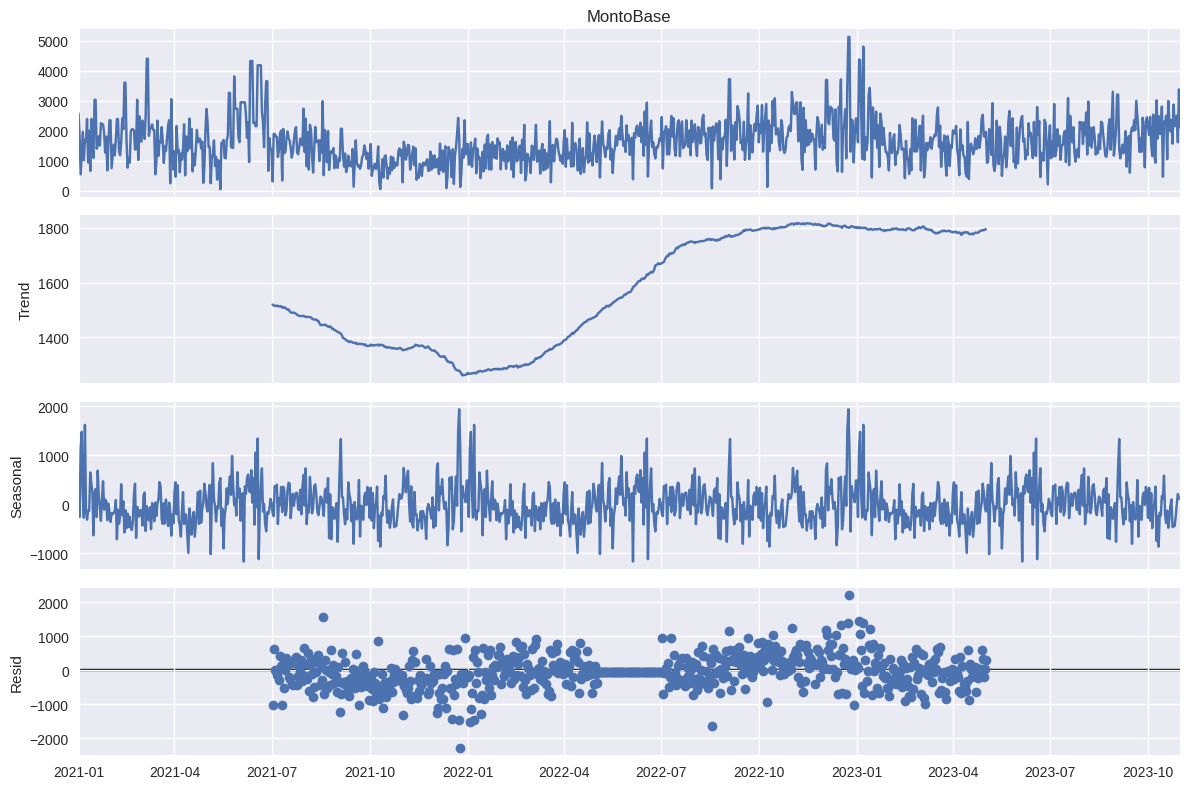

In [ ]:
rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df_arima_desde_2021["MontoBase"], model = "add", period=365)
a.plot();

In [ ]:
# dividir en orden cronologico, entrenando sin el mes de octubre
train_size_d21 = int(len(df_arima_desde_2021) - 31)
train_d21, test_d21 = df_arima_desde_2021[0:train_size_d21], df_arima_desde_2021[train_size_d21:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_d21.shape, test_d21.shape

((1003, 1), (31, 1))

In [ ]:
print(train_d21)

                 MontoBase
FechaMovimiento           
2021-01-01       2569.5190
2021-01-02       1822.6310
2021-01-03        543.4340
2021-01-04       1221.7920
2021-01-05       1963.7850
...                    ...
2023-09-26       2428.3650
2023-09-27       2002.2241
2023-09-28        779.7913
2023-09-29       2314.3827
2023-09-30       2443.0856

[1003 rows x 1 columns]


In [ ]:
# # posibles valores para m = 7_diarios, 12_mensuales, 52_semanales
# modelo_auto=auto_arima(train_d21,start_p=0,d=1,start_q=0,
#           max_p=4,max_d=2,max_q=4, start_P=0,
#           D=1, start_Q=0, max_P=2,max_D=1,
#           max_Q=2, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)
# print(modelo_auto)
# # ## se tiene el problema de q se usa toda la memoria RAM 12.7GB cuando se tiene m=365 (supuestamente periodos anuales)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# print(modelo_auto.summary())

In [ ]:
# arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,2), seasonal_order = (2,1,0,12))
arima_model_d21 = SARIMAX(train_d21["MontoBase"], order = (4,1,3), seasonal_order = (2,1,0,12))
arima_result_d21 = arima_model_d21.fit()
arima_result_d21.summary()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of N

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           MontoBase   No. Observations:                 1003
Model:             SARIMAX(4, 1, 3)x(2, 1, [], 12)   Log Likelihood               -8033.646
Date:                             Mon, 18 Mar 2024   AIC                          16087.293
Time:                                     00:02:11   BIC                          16136.270
Sample:                                 01-01-2021   HQIC                         16105.917
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7516      0.038    -19.920      0.000      -0.826      -0.678
ar.L2         -0.6420      0.051    -12.662      0.000      -0.741      -0.543
ar.L3          0.2394      0.051      4.739      0.000       0.140       0.338
ar.L4          0.0849      0.045      1.907      0.057      -0.002       0.172
ma.L1          0.0012      1.414      0.001      0.999      -2.769       2.772
ma.L2         -0.0012      1.415     -0.001      0.999      -2.774       2.772
ma.L3         -1.0000      0.054    -18.676      0.000      -1.105      -0.895
ar.S.L12      -0.5290      0.043    -12.298      0.000      -0.613      -0.445
ar.S.L24      -0.2141      0.044     -4.873      0.000      -0.300      -0.128
sigma2      9.086e+05   3.11e-06   2.92e+11      0.000    9.09e+05    9.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.13   Jarque-Bera (JB):                74.93
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.19
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.06e+27. Standard errors may be unstable.
"""

In [ ]:
arima_pred_d21 = arima_result_d21.predict(start = len(df_arima_desde_2021), end = len(df_arima_desde_2021)+29, typ="levels")
print(arima_pred_d21)
# o start = 965 , end = 994 en primerasucursal
# o start = 967 , end = 996 en segundasucursal

2023-11-01   2059.9173
2023-11-02   2028.9531
2023-11-03   1296.1748
2023-11-04   2121.5924
2023-11-05   2209.8814
2023-11-06   2189.0510
2023-11-07   2331.9021
2023-11-08   2027.4162
2023-11-09   2314.0546
2023-11-10   1169.2804
2023-11-11   1517.1694
2023-11-12   1668.2517
2023-11-13   2009.3163
2023-11-14   2039.6591
2023-11-15   1367.9868
2023-11-16   2095.4141
2023-11-17   2181.9285
2023-11-18   2175.5462
2023-11-19   2354.3565
2023-11-20   2030.7874
2023-11-21   2298.3392
2023-11-22   1176.8795
2023-11-23   1522.7882
2023-11-24   1660.3921
2023-11-25   2006.9558
2023-11-26   2028.6058
2023-11-27   1361.0443
2023-11-28   2115.5193
2023-11-29   2198.4827
2023-11-30   2185.9627
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Convertir el índice de las predicciones de ARIMA a un rango de fechas
fechas_prediccion = date_range(start=df_noviembre_desde_2021['FechaMovimiento'].iloc[0], periods=len(arima_pred_d21))

# Crear un DataFrame con las fechas y las predicciones de ARIMA
df_predicciones_arima_21 = DataFrame({'FechaMovimiento': fechas_prediccion, 'Ventas_ARIMA': arima_pred_d21.values})

# print(arima_pred_d21)
print(df_predicciones_arima_21)

   FechaMovimiento  Ventas_ARIMA
0       2023-11-01     2059.9173
1       2023-11-02     2028.9531
2       2023-11-03     1296.1748
3       2023-11-04     2121.5924
4       2023-11-05     2209.8814
5       2023-11-06     2189.0510
6       2023-11-07     2331.9021
7       2023-11-08     2027.4162
8       2023-11-09     2314.0546
9       2023-11-10     1169.2804
10      2023-11-11     1517.1694
11      2023-11-12     1668.2517
12      2023-11-13     2009.3163
13      2023-11-14     2039.6591
14      2023-11-15     1367.9868
15      2023-11-16     2095.4141
16      2023-11-17     2181.9285
17      2023-11-18     2175.5462
18      2023-11-19     2354.3565
19      2023-11-20     2030.7874
20      2023-11-21     2298.3392
21      2023-11-22     1176.8795
22      2023-11-23     1522.7882
23      2023-11-24     1660.3921
24      2023-11-25     2006.9558
25      2023-11-26     2028.6058
26      2023-11-27     1361.0443
27      2023-11-28     2115.5193
28      2023-11-29     2198.4827
29      20

  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  1999.7321       1875.0166    2192.2920     2059.9173
1      2023-11-02  1011.2892       1688.5578    1823.4390     2028.9531
2      2023-11-03  2343.7883       1913.3475    1408.4690     1296.1748
3      2023-11-04  1673.2089       2292.4028    1329.1290     2121.5924
4      2023-11-05  1181.9289       1717.8459    1584.2465     2209.8814
  FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0      2023-11-01  1999.7321       1875.0166    2192.2920     2059.9173
1      2023-11-02  1011.2892       1688.5578    1823.4390     2028.9531
2      2023-11-03  2343.7883       1913.3475    1408.4690     1296.1748
3      2023-11-04  1673.2089       2292.4028    1329.1290     2121.5924
4      2023-11-05  1181.9289       1717.8459    1584.2465     2209.8814


<ipython-input-277-5898d4da88ea>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


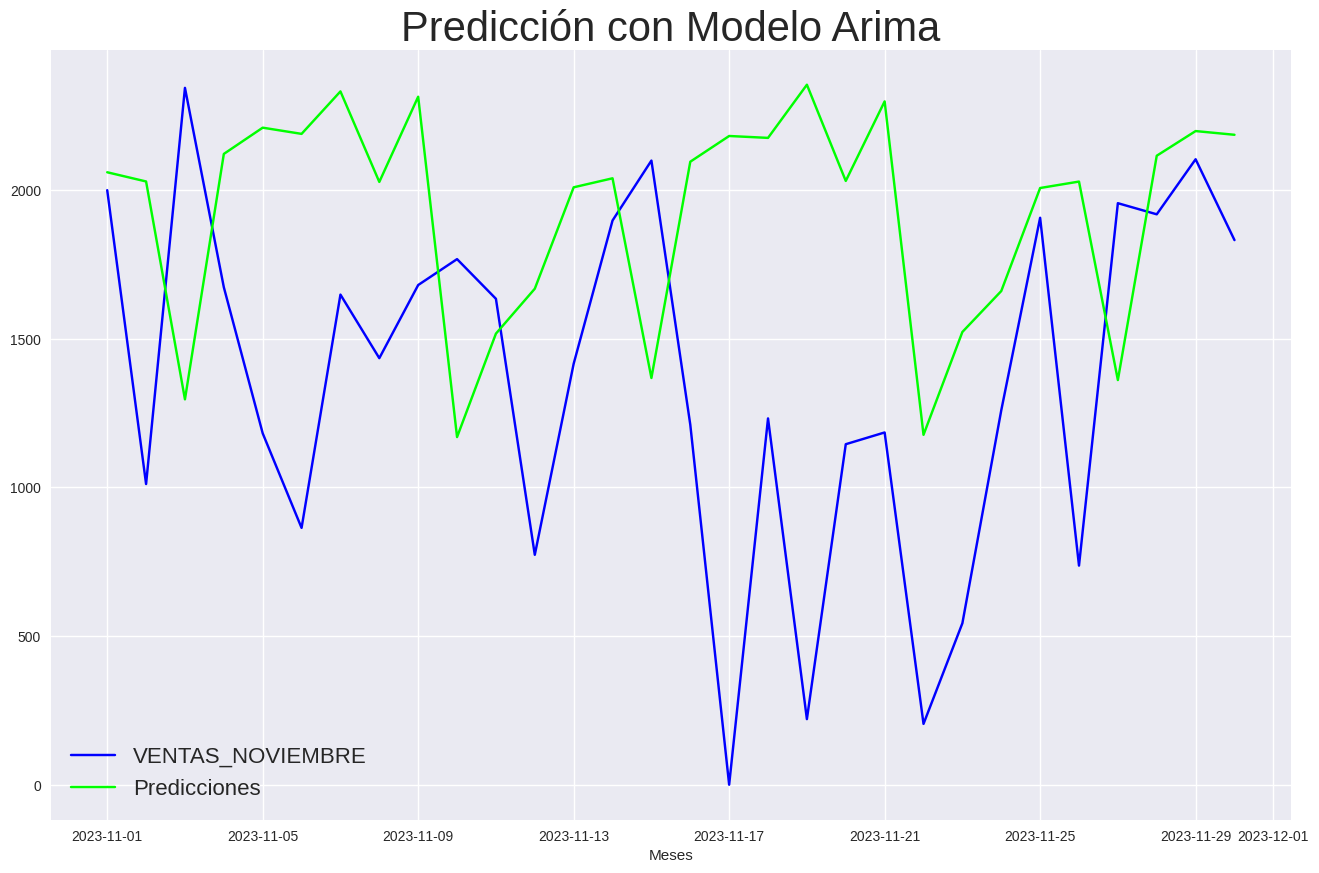

In [ ]:
print(df_noviembre_desde_2021.head())
#df_noviembre_desde_2021.set_index('FechaMovimiento', inplace=True)
print(df_noviembre_desde_2021.head())

style.use('seaborn')
rcParams["figure.figsize"] = (16, 10)
#plot(test_d21["MontoBase"],color="blue" ,label="VENTAS")
plot(df_noviembre_desde_2021["FechaMovimiento"], df_noviembre_desde_2021["MontoBase"],color="BLUE" ,label="VENTAS_NOVIEMBRE")
plot(df_predicciones_arima_21['FechaMovimiento'],df_predicciones_arima_21['Ventas_ARIMA'], color="lime", label="Predicciones")
title("Predicción con Modelo Arima", fontsize=30);
xlabel('Meses')
ylabel('')
legend( fontsize=16);
show();

### Evaluar

In [ ]:
# Suponiendo que df_noviembre_sumaT y predictions_future están en el mismo orden
df_noviembre_desde_2021['Ventas_ARIMA'] = df_predicciones_arima_21['Ventas_ARIMA']

# Imprimir el resultado
print(df_noviembre_desde_2021.head(30))

   FechaMovimiento  MontoBase  Ventas_PROPHET  Ventas_LSTM  Ventas_ARIMA
0       2023-11-01  1999.7321       1875.0166    2192.2920     2059.9173
1       2023-11-02  1011.2892       1688.5578    1823.4390     2028.9531
2       2023-11-03  2343.7883       1913.3475    1408.4690     1296.1748
3       2023-11-04  1673.2089       2292.4028    1329.1290     2121.5924
4       2023-11-05  1181.9289       1717.8459    1584.2465     2209.8814
5       2023-11-06   863.7984       1853.3157    1885.8668     2189.0510
6       2023-11-07  1648.4580       1712.0499    2734.3052     2331.9021
7       2023-11-08  1434.6711       1786.3423    1035.5312     2027.4162
8       2023-11-09  1680.6493       1581.1540    1566.1948     2314.0546
9       2023-11-10  1767.7892       1788.3776    1808.8762     1169.2804
10      2023-11-11  1634.3693       2151.4295    1785.7723     1517.1694
11      2023-11-12   773.2943       1562.8089    1785.7444     1668.2517
12      2023-11-13  1415.9722       1686.5002    30

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

Evaluation metric results:  
MSE is : 857731.5221224098
MAE is : 768.0776230356411
R2 is : -1.3615912130024896 %
------------------------------
MRSE is : 926.1379606313575
MAPE is : 103.3570196515878 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**RESULTADOS** ▶

Con datos rellenados con valores del dia anterior
order = (4,1,0), seasonal_order = (2,1,0,12)
- MRSE is : 1447.748431732042
- MAPE is : 165.23594135401524 %

order = (5,1,2), seasonal_order = (2,1,2,12)
+ OTRA RECTA

order = (5,1,3), seasonal_order = (2,1,0,12)
- MRSE is : 1032.9433790791031
- MAPE is : 114.77767564273447 %

___
order = (4,1,3), seasonal_order = (2,1,0,12)
- MRSE is : 926.1379606313575
- MAPE is : 103.3570196515878 %
___

order = (3,1,3), seasonal_order = (2,1,0,12)
- MRSE is : 1087.9505677700024
- MAPE is : 123.28955616439148 %

order = (4,1,2), seasonal_order = (2,1,0,12)
- MRSE is : 960.9337271439128
- MAPE is : 106.338996906153 %

order = (4,1,3), seasonal_order = (2,1,1,12)
- MRSE is : 854.7197252859681
- MAPE is : 104.53773677658769 %

order = (4,1,3), seasonal_order = (1,1,0,12)
- MRSE is : 944.3989135615228
- MAPE is : 103.73373246423365 %

order = (5,1,3), seasonal_order = (1,1,0,12)
- MRSE is : 966.5065018277994
- MAPE is : 105.85920894539773 %

order = (4,1,3), seasonal_order = (3,1,0,12)
- MRSE is : 1032.3660287270409
- MAPE is : 116.00014637586828 %


# TODAS LAS EVALUACIONES

In [ ]:
print("--"*10,"EVALUACIÓN CON TODOS LOS DATOS","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_sumaT['MontoBase'],df_noviembre_sumaT['Ventas_ARIMA'])
print("--"*10,"EVALUACIÓN DESDE EL 2021","--"*10)
print("--"*5,"PROPHET","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_PROPHET'])
print("--"*5,"LSTM","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_LSTM'])
print("--"*5,"ARIMA","--"*5)
evaluacion_metrica(df_noviembre_desde_2021['MontoBase'],df_noviembre_desde_2021['Ventas_ARIMA'])

-------------------- EVALUACIÓN CON TODOS LOS DATOS --------------------
---------- PROPHET ----------
Evaluation metric results:  
MSE is : 579555.4652933188
MAE is : 606.2327973754228
R2 is : -0.5956893957885148 %
------------------------------
MRSE is : 761.2854033102952
MAPE is : 92.2632432603097 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


---------- LSTM ----------
Evaluation metric results:  
MSE is : 832099.0660667937
MAE is : 717.7978252864581
R2 is : -1.2910174012358087 %
------------------------------
MRSE is : 912.1946426431114
MAPE is : 100.21755827874483 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


---------- ARIMA ----------
Evaluation metric results:  
MSE is : 886419.954812642
MAE is : 777.9722920608631
R2 is : -1.4405790417212252 %
------------

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<ipython-input-257-b20ea7382dad>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


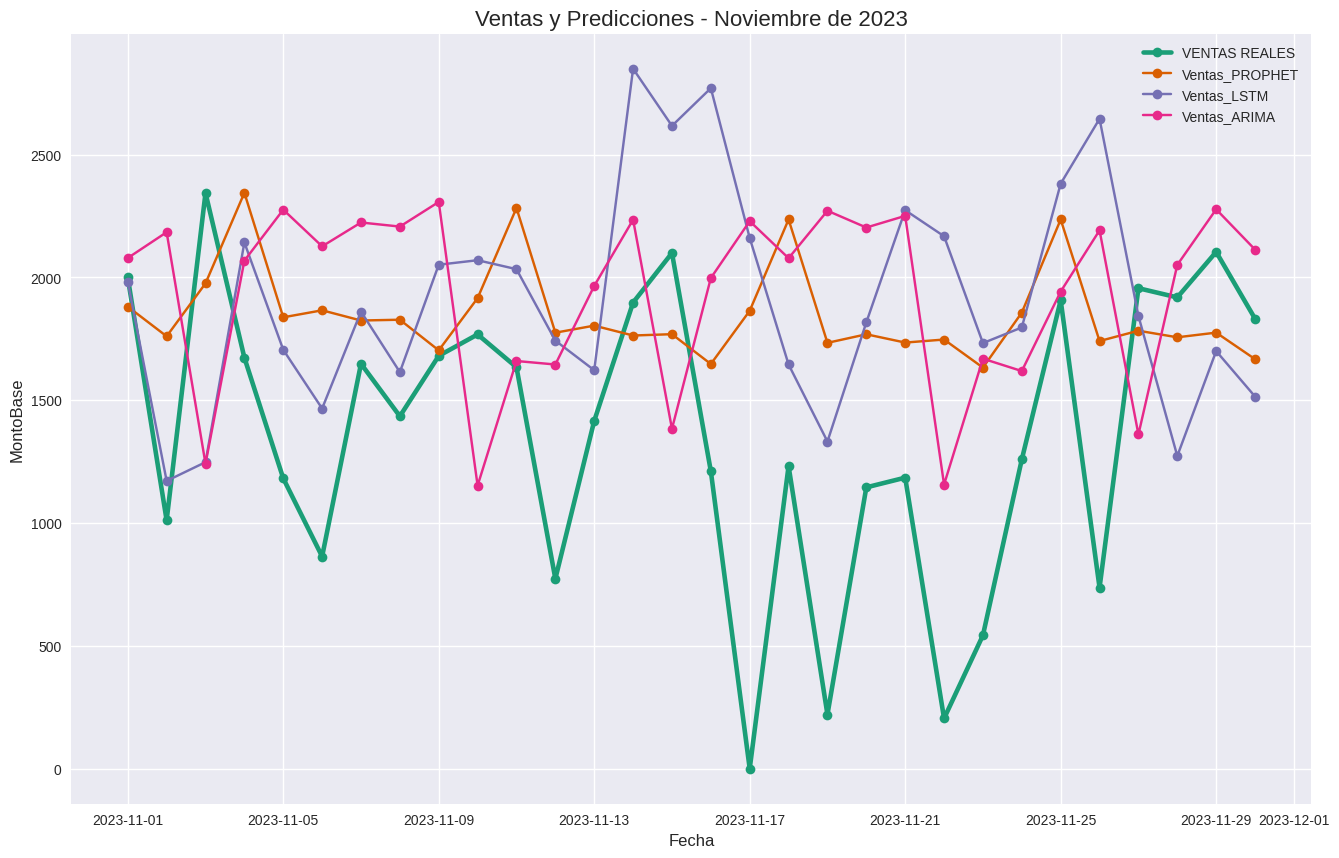

In [ ]:
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_sumaT
figure(figsize=(16, 10))
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_sumaT['FechaMovimiento'], df_noviembre_sumaT['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()

<ipython-input-258-ae4643b71aae>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


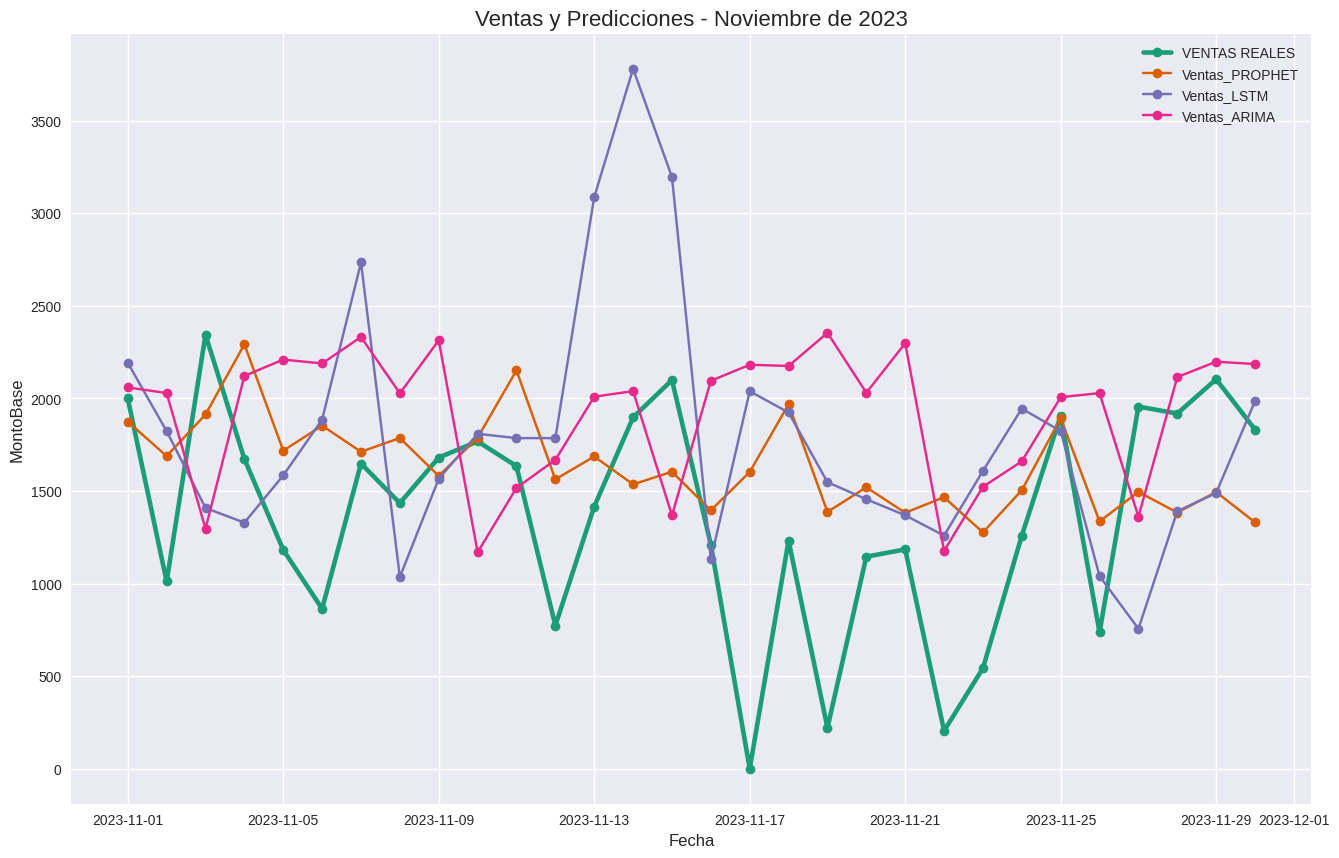

In [ ]:
# Establecer el estilo de Seaborn
style.use('seaborn')
set_palette("Dark2")

# Graficar los datos para df_noviembre_desde_2021
figure(figsize=(16, 10))
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['MontoBase'], label='VENTAS REALES', marker='o', linewidth=3.3)
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_PROPHET'], label='Ventas_PROPHET', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_LSTM'], label='Ventas_LSTM', marker='o')
plot(df_noviembre_desde_2021['FechaMovimiento'], df_noviembre_desde_2021['Ventas_ARIMA'], label='Ventas_ARIMA', marker='o')
title('Ventas y Predicciones - Noviembre de 2023', fontsize=16)
xlabel('Fecha', fontsize=12)
ylabel('MontoBase', fontsize=12)
legend()
show()